In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 
from IPython.display import Markdown
from tabulate import tabulate
from IPython.display import HTML
from pathlib import Path

In [2]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Read Dataset Characterstics and Study Results 

In [6]:
dataset_dir = Path("Dataset")
results_dir = dataset_dir / "Results"

# OpenAlex paths
excel_path_campbell_oa = results_dir / "sr_samples_campbell_openalex.xlsx"
excel_path_cee_oa = results_dir / "sr_samples_cee_openalex.xlsx"
excel_path_cochrane_oa = results_dir / "sr_samples_cochrane_openalex.xlsx"

# SemanticScholar paths
excel_path_campbell_ss = results_dir / "sr_samples_campbell_semanticscholar.xlsx"
excel_path_cee_ss = results_dir / "sr_samples_cee_semanticscholar.xlsx"
excel_path_cochrane_ss = results_dir / "sr_samples_cochrane_semanticscholar.xlsx"

#sr data
original_sr_campbell_oa = pd.read_excel(excel_path_campbell_oa , sheet_name='sys_rev_data_oa')
original_sr_cee_oa = pd.read_excel(excel_path_cee_oa , sheet_name='sys_rev_data_oa')
original_sr_cochrane_oa = pd.read_excel(excel_path_cochrane_oa , sheet_name='sys_rev_data_oa')

original_sr_campbell_ss = pd.read_excel(excel_path_campbell_ss , sheet_name='sys_rev_data_ss')
original_sr_cee_ss = pd.read_excel(excel_path_cee_ss , sheet_name='sys_rev_data_ss')
original_sr_cochrane_ss = pd.read_excel(excel_path_cochrane_ss , sheet_name='sys_rev_data_ss')

# original SR data 
baseline_review_data_oa = pd.concat([original_sr_cee_oa, original_sr_campbell_oa, original_sr_cochrane_oa],ignore_index=True)
baseline_review_data_ss = pd.concat([original_sr_cee_ss, original_sr_campbell_ss, original_sr_cochrane_ss],ignore_index=True)

### Read Included Articles / Review Question Characteristics


In [3]:
#included article data
included_article_campbell_oa = pd.read_excel(excel_path_campbell_oa , sheet_name='sys_rev_included_data_oa')
included_article_cee_oa = pd.read_excel(excel_path_cee_oa , sheet_name='sys_rev_included_data_oa')
included_article_cochrane_oa = pd.read_excel(excel_path_cochrane_oa , sheet_name='sys_rev_included_data_oa')

included_article_campbell_ss = pd.read_excel(excel_path_campbell_ss , sheet_name='sys_rev_included_data_ss')
included_article_cee_ss = pd.read_excel(excel_path_cee_ss , sheet_name='sys_rev_included_data_ss')
included_article_cochrane_ss = pd.read_excel(excel_path_cochrane_ss , sheet_name='sys_rev_included_data_ss')


def consolidate_included_article_ids(row):
    return row['included_doi'] or row['included_pmid'] or row['included_mag_id']

included_article_campbell_oa['consolidated_ids'] = included_article_campbell_oa.apply(consolidate_included_article_ids, axis=1)
included_article_cee_oa['consolidated_ids'] = included_article_cee_oa.apply(consolidate_included_article_ids, axis=1)
included_article_cochrane_oa['consolidated_ids'] = included_article_cochrane_oa.apply(consolidate_included_article_ids, axis=1)

included_article_campbell_ss['consolidated_ids'] = included_article_campbell_ss.apply(consolidate_included_article_ids, axis=1)
included_article_cee_ss['consolidated_ids'] = included_article_cee_ss.apply(consolidate_included_article_ids, axis=1)
included_article_cochrane_ss['consolidated_ids'] = included_article_cochrane_ss.apply(consolidate_included_article_ids, axis=1)

included_campbell_oa = included_article_campbell_oa.query('not no_data_no_id.isna()')
included_campbell_ss = included_article_campbell_ss.query('not no_data_no_id.isna()')

included_cee_oa = included_article_cee_oa.query('not no_data_no_id.isna()')
included_cee_ss = included_article_cee_ss.query('not no_data_no_id.isna()')

included_cochrane_oa = included_article_cochrane_oa.query('not no_data_no_id.isna()')
included_cochrane_ss = included_article_cochrane_ss.query('not no_data_no_id.isna()')

included_all_oa = pd.concat([included_cee_oa, included_campbell_oa, included_cochrane_oa], ignore_index=True)
included_all_ss = pd.concat([included_cee_ss, included_campbell_ss, included_cochrane_ss], ignore_index = True)

included_all_oa['no_id'] = np.where(
    (included_all_oa['no_data_no_id'] == 1) & (included_all_oa['no_data_from_api'] == 0),
    1,
    0
)
included_all_oa.drop(columns=['not_retrieved'], inplace=True)

# For the DataFrame `included_all_ss`
included_all_ss['no_id'] = np.where(
    (included_all_ss['no_data_no_id'] == 1) & (included_all_ss['no_data_from_api'] == 0),
    1,
    0
)
included_all_ss.drop(columns=['not_retrieved'], inplace=True)

# RESULTS TABLE 3 : Median number of included articles (IQR) and average intracluster semantic similarity (+/- SD) for Systematic Reviews in each Source Database, and All Reviews in the Dataset

In [4]:
#| label: tbl-included_articles
#| tbl-cap: 'Median number of included articles (IQR) and average intracluster semantic similarity (+/- SD) for Systematic Reviews in each Source Database, and All Reviews in the Dataset'

original_sr_included_merge = pd.merge(included_all_oa, baseline_review_data_oa, how='left', left_on='original_sr_id', right_on = 'id', suffixes=('_included', '_original_sr'))
# Define IQR function
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)


    
# Initial grouping and count
col_interest = ['source_database', 'original_sr_id', 'intra_cluster_similarity', 'consolidated_ids']
col_groupby = ['source_database', 'original_sr_id', 'intra_cluster_similarity']
included_summary = original_sr_included_merge[col_interest].groupby(col_groupby).agg({'consolidated_ids': 'count'}).reset_index()
included_summary.rename(columns={'consolidated_ids': 'included_count'}, inplace=True)

# Second-level grouping with median, IQR, mean, and std calculations
included_summary_database = included_summary.groupby(['source_database']).agg({'included_count': ['median', iqr], 'intra_cluster_similarity': ['median', iqr]}).reset_index()

# Flatten the MultiIndex
included_summary_database.columns = ['_'.join(col).rstrip('_') for col in included_summary_database.columns.values]

# Create a summary row based on the included_summary DataFrame
new_row_data = {
    'source_database': 'All Reviews',
    'included_count_median': included_summary['included_count'].median(),
    'included_count_iqr': iqr(included_summary['included_count']),
    'intra_cluster_similarity_median': included_summary['intra_cluster_similarity'].median(),
    'intra_cluster_similarity_iqr': iqr(included_summary['intra_cluster_similarity'])
}

# Append the new summary row
included_summary_database = pd.concat([included_summary_database, pd.DataFrame([new_row_data])], ignore_index=True)

# Function to format rows for the Markdown table
def format_row(row):
    median_iqr_count = f"{row['included_count_median']} ({row['included_count_iqr']})"
    median_iqr_intrasim= f"{row['intra_cluster_similarity_median']:.3f} ({row['intra_cluster_similarity_iqr']:.3f})"
    return f"| {row['source_database']} | {median_iqr_count} | {median_iqr_intrasim} |"

# Create Markdown table headers
md_table = "|Source Database|Number of Included Articles (IQR)|Intra-Cluster Similarity (IQR)|\n"
md_table += "|-----------------|---------------------------------|---------------------------------------------|\n"

# Add rows to the Markdown table
for idx, row in included_summary_database.iterrows():
    md_table += format_row(row) + '\n'

Markdown(md_table)

|Source Database|Number of Included Articles (IQR)|Intra-Cluster Similarity (IQR)|
|-----------------|---------------------------------|---------------------------------------------|
| CEE | 50.5 (28.25) | 0.830 (0.078) |
| Campbell | 22.0 (53.0) | 0.829 (0.035) |
| Cochrane | 15.0 (58.0) | 0.864 (0.047) |
| All Reviews | 42.0 (51.5) | 0.846 (0.065) |


### Theoretical Maximum Achievable Recall by Automated Citation Searching


In [5]:
#this may be come a supplementary table as it oulines tehoretica lrecall for all reviews - but we will decide on that later 

def calculate_retrieval_stats(df, original_sr_id, included_num):
    stats = {}
    mask = df['original_sr_id'] == original_sr_id
    filtered_df = df[mask]

    stats['no_id_num'] = filtered_df['no_id'].sum()
    stats['no_data_from_api_num'] = filtered_df['no_data_from_api'].sum()
    stats['no_id_no_api_num'] = filtered_df['no_data_no_id'].sum()
    stats['api_success_retrieved_num'] = sum(filtered_df['no_data_no_id'] == 0)
    stats['retrievable_id_num'] = included_num - stats['no_id_num']
    

    if included_num != 0:
        stats['no_id_percentage'] = round((stats['no_id_num'] / included_num) * 100, 1)
        stats['no_data_api_percentage'] = round((stats['no_data_from_api_num'] / included_num) * 100, 1)
        stats['api_success_retrieved_percentage'] = round((stats['api_success_retrieved_num'] / included_num) * 100, 1)
        stats['retrievable_id_percentage'] = round((stats['retrievable_id_num'] / included_num) * 100, 1)

        stats['no_id_percentage_with_counts'] = f"{stats['no_id_percentage']} % (n={stats['no_id_num']})"
        stats['retrievable_id_percentage_with_counts'] = f"{stats['retrievable_id_percentage']} % (n={stats['retrievable_id_num']})"
        stats['no_data_api_percentage_with_counts'] = f"{stats['no_data_api_percentage']} % (n={stats['no_data_from_api_num']})"
        stats['success_retrieved_percentage_with_counts'] = f"{stats['api_success_retrieved_percentage']} % (n={stats['api_success_retrieved_num']})"
    else:
        stats['no_id_percentage'] = 0
        stats['no_data_api_percentage'] = 0
        stats['success_retrieved_percentage'] = 0
        stats['no_id_percentage_with_counts'] = f"{stats['no_id_percentage']}% (n={stats['no_id_num']})"
        stats['no_data_api_percentage_with_counts'] = f"{stats['no_data_api_percentage']}% (n={stats['no_data_from_api_num']})"
        stats['success_retrieved_percentage_with_counts'] = f"{stats['success_retrieved_percentage']}% (n={stats['success_retrieved_num']})"
        stats['retrievable_id_percentage_with_counts'] = f"{stats['retrievable_id_percentage']}% (n={stats['retrievable_id_num']})"

    return stats

original_sr_all = baseline_review_data_oa.copy()

for original_sr_id in original_sr_all['id'].unique():
    mask_oa = included_all_oa['original_sr_id'] == original_sr_id
    mask_ss = included_all_ss['original_sr_id'] == original_sr_id
    included_num = len(included_all_oa[mask_oa])

    stats_oa = calculate_retrieval_stats(included_all_oa, original_sr_id, included_num)
    stats_ss = calculate_retrieval_stats(included_all_ss, original_sr_id, included_num)

    original_sr_all.loc[original_sr_all['id'] == original_sr_id, 'included_num'] = included_num

    for prefix, stats in {'oa': stats_oa, 'ss': stats_ss}.items():
        for key, value in stats.items():
            original_sr_all.loc[original_sr_all['id'] == original_sr_id, f"{key}_{prefix}"] = value

extract_col = ['source_database', 'included_num', 'retrievable_id_percentage_with_counts_ss','success_retrieved_percentage_with_counts_oa','success_retrieved_percentage_with_counts_ss']
original_sr_performance_df = original_sr_all[extract_col].copy()
original_sr_performance_df.rename(columns = {'retrievable_id_percentage_with_counts_ss':'retrievable_id_percentage_with_counts'}, inplace = True)

extract_col_new = ['source_database', 'included_num', 'retrievable_id_percentage_with_counts','success_retrieved_percentage_with_counts_oa','success_retrieved_percentage_with_counts_ss']

## change column names 
target_col_names = ['Source Database', 'Number of Included Articles', 'Percentage of Included Articles with Retrievable IDs', 'Maximum Theoretical Recall (OpenAlex)', 'Maximum Theoretical Recall (Semantic Scholar)']
col_name_mapping = dict(zip(extract_col_new, target_col_names))
original_sr_performance_df.rename(columns = col_name_mapping, inplace=True)


def iqr(x): 
    return round(x.quantile(0.75) - x.quantile(0.25),2)

def percentage_achieve_100(x): 
    return round((x.sum() / len(x)) * 100, 1)
raw_col = ['source_database', 'included_num', 'retrievable_id_percentage_oa','api_success_retrieved_percentage_oa','api_success_retrieved_percentage_ss']
# Prepare raw_data DataFrame
raw_data = original_sr_all[raw_col].copy()
raw_data['retrieved_id_100'] = (raw_data['retrievable_id_percentage_oa'] == 100).astype(int)
raw_data['retrieved_api_100_oa'] = (raw_data['api_success_retrieved_percentage_oa'] == 100).astype(int)
raw_data['retrieved_api_100_ss'] = (raw_data['api_success_retrieved_percentage_ss'] == 100).astype(int)

# Prepare the summary DataFrame
agg_columns = {
    'included_num': ['median', iqr],
    'retrievable_id_percentage_oa': ['median', iqr],
    'api_success_retrieved_percentage_oa': ['median', iqr],
    'api_success_retrieved_percentage_ss': ['median', iqr],
    'retrieved_id_100': [percentage_achieve_100, 'sum'],
    'retrieved_api_100_oa': [percentage_achieve_100, 'sum'],
    'retrieved_api_100_ss': [percentage_achieve_100, 'sum']
}

original_sr_performance_df_summary = (
    raw_data
    .groupby(['source_database'])
    .agg(agg_columns)
    .reset_index()
)

# Flatten the MultiIndex for columns
original_sr_performance_df_summary.columns = [
    '_'.join(col).rstrip('_') 
    for col in original_sr_performance_df_summary.columns.values
]

# Prepare summary data for 'All Reviews'
extra_raw_all_reviews = {
    'source_database': 'All Reviews',
    'included_num_median': raw_data['included_num'].median(),
    'included_num_iqr': iqr(raw_data['included_num']),
    'retrievable_id_percentage_oa_median': raw_data['retrievable_id_percentage_oa'].median(),
    'retrievable_id_percentage_oa_iqr': iqr(raw_data['retrievable_id_percentage_oa']),
    'api_success_retrieved_percentage_oa_median': raw_data['api_success_retrieved_percentage_oa'].median(),
    'api_success_retrieved_percentage_oa_iqr': iqr(raw_data['api_success_retrieved_percentage_oa']),
    'api_success_retrieved_percentage_ss_median': raw_data['api_success_retrieved_percentage_ss'].median(),
    'api_success_retrieved_percentage_ss_iqr': iqr(raw_data['api_success_retrieved_percentage_ss']),
    'retrieved_id_100_percentage_achieve_100': percentage_achieve_100(raw_data['retrieved_id_100']),
    'retrieved_api_100_oa_percentage_achieve_100': percentage_achieve_100(raw_data['retrieved_api_100_oa']),
    'retrieved_api_100_ss_percentage_achieve_100': percentage_achieve_100(raw_data['retrieved_api_100_ss']),
    'retrieved_id_100_sum': raw_data['retrieved_id_100'].sum(),
    'retrieved_api_100_oa_sum': raw_data['retrieved_api_100_oa'].sum(),
    'retrieved_api_100_ss_sum': raw_data['retrieved_api_100_ss'].sum()
}

all_review_summary = pd.DataFrame([extra_raw_all_reviews])

# Concatenate the summary and all_review_summary DataFrames
original_sr_performance_df_summary = pd.concat(
    [original_sr_performance_df_summary, all_review_summary], 
    ignore_index=True
)
custom_order_dict = {'All Reviews' : 1, 'CEE' : 2, 'Campbell' : 3, 'Cochrane' : 4}

# Sort DataFrame using a custom key function
original_sr_performance_df_summary  = original_sr_performance_df_summary.sort_values(
    by='source_database',
    key=lambda x: x.map(custom_order_dict)
).reset_index(drop=True)

# Unused Table

In [6]:
#| label: tbl-percentage_of_review_100recall
#| tbl-cap: 'Percentage of Reviews with 100% Theoretical Recall by Automated Citation Searching for each Systematic Review Source Database, by API (OpenAlex / Semantic Scholar)'

def format_row(row): 
    percentage_num_retrieved_id = f"{row['retrieved_id_100_percentage_achieve_100']}% (n={row['retrieved_id_100_sum']})"
    percentage_num_retrieved_id= f"{row['retrieved_api_100_oa_percentage_achieve_100']}% (n={row['retrieved_api_100_oa_sum']})"
    percentage_num_retrieved_api_ss = f"{row['retrieved_api_100_ss_percentage_achieve_100']}% (n={row['retrieved_api_100_ss_sum']})"
    return f"| {row['source_database']} | {percentage_num_retrieved_id} | {percentage_num_retrieved_id} | {percentage_num_retrieved_api_ss} |"

md_table = "| Source Database| % of Reviews with 100% Retrievable IDs | % Of Reviews with 100% Retrievable Recall (OpenAlex) | % Of Reviews with 100% Retrievable Recall (Semantic Scholar) | \n"
md_table += "|---------------------------------|------------------------------------------------------|---------------------------------------------------------------------|---------------------------------------------------------------------|\n"

for idx, row in original_sr_performance_df_summary.iterrows():
    md_table += format_row(row) + '\n'
Markdown(md_table)

| Source Database| % of Reviews with 100% Retrievable IDs | % Of Reviews with 100% Retrievable Recall (OpenAlex) | % Of Reviews with 100% Retrievable Recall (Semantic Scholar) | 
|---------------------------------|------------------------------------------------------|---------------------------------------------------------------------|---------------------------------------------------------------------|
| All Reviews | 18.5% (n=5) | 18.5% (n=5) | 14.8% (n=4) |
| CEE | 20.0% (n=2) | 20.0% (n=2) | 10.0% (n=1) |
| Campbell | 11.1% (n=1) | 11.1% (n=1) | 11.1% (n=1) |
| Cochrane | 25.0% (n=2) | 25.0% (n=2) | 25.0% (n=2) |


# Table 8: Median % (IQR) of included articles with Valid IDs extracted from systematic reviews in dataset, and baseline retrievability rate of included articles across both APIs: (OpenAlex, Semantic Scholar)

In [7]:
#| label: tbl-theoretical_max_recall_summary
#| tbl-cap: 'Median (IQR) Theoretical Maximum Achievable Recall by Automated Citation Searching for each Systematic Review Source Database, by API (OpenAlex / Semantic Scholar)'


 
def format_row(row): 
    median_iqr_retrievable_id = f"{row['retrievable_id_percentage_oa_median']} ({row['retrievable_id_percentage_oa_iqr']})"
    median_iqr_api_success_retrieved_oa = f"{row['api_success_retrieved_percentage_oa_median']} ({row['api_success_retrieved_percentage_oa_iqr']})"
    median_iqr_api_success_retrieved_ss = f"{row['api_success_retrieved_percentage_ss_median']} ({row['api_success_retrieved_percentage_ss_iqr']})"
    return f"| {row['source_database']} | {median_iqr_retrievable_id} | {median_iqr_api_success_retrieved_oa} | {median_iqr_api_success_retrieved_ss} |"

md_table = "| Source Database| Median % (IQR) of Included Articles with Retrievable IDs | Median (IQR) Maximum Theoretical Recall (OpenAlex) | Median (IQR) Maximum Theoretical Recall (Semantic Scholar) | \n"
md_table += "|---------------------------------|------------------------------------------------------|---------------------------------------------------------------------|---------------------------------------------------------------------|\n"

for idx, row in original_sr_performance_df_summary.iterrows():
    md_table += format_row(row) + '\n'

Markdown(md_table)

| Source Database| Median % (IQR) of Included Articles with Retrievable IDs | Median (IQR) Maximum Theoretical Recall (OpenAlex) | Median (IQR) Maximum Theoretical Recall (Semantic Scholar) | 
|---------------------------------|------------------------------------------------------|---------------------------------------------------------------------|---------------------------------------------------------------------|
| All Reviews | 86.4 (12.05) | 85.7 (13.2) | 85.7 (16.4) |
| CEE | 84.4 (15.52) | 81.6 (15.52) | 83.35 (17.65) |
| Campbell | 89.1 (6.3) | 86.4 (4.6) | 87.0 (4.6) |
| Cochrane | 85.9 (15.2) | 85.9 (15.2) | 84.0 (18.23) |


# Table 5 : Median (IQR) Precision, F1 score, F2 score and F3 score for all Search Strategies employed by the Systematic Reviews in the Dataset

In [8]:
#| label: tbl-reference_search_strat_perf
#| tbl-cap: 'Median (IQR) Precision, F1 score, F2 score and F3 score for all Search Strategies employed by the Systematic Reviews in the Dataset'
# Function to calculate median and IQR

def iqr(x): 
    return round(x.quantile(0.75) - x.quantile(0.25),3)
baseline_review_data_oa['precision_percentage'] = baseline_review_data_oa['precision']*100
relevant_col = ['source_database', 'precision_percentage', 'f1_score', 'f2_score', 'f3_score']

baseline_performance_summary_df = baseline_review_data_oa[relevant_col].groupby('source_database').agg({
    'precision_percentage': ['median', iqr], 'f1_score': ['median', iqr], 'f2_score': ['median', iqr], 'f3_score': ['median', iqr]
    }).reset_index()

baseline_performance_summary_df.columns = ['_'.join(col).rstrip('_') for col in baseline_performance_summary_df.columns.values]

all_review_row = {
    'source_database': 'All Reviews',
    'precision_percentage_median': baseline_review_data_oa['precision_percentage'].median(),
    'precision_percentage_iqr': iqr(baseline_review_data_oa['precision_percentage']),
    'f1_score_median': baseline_review_data_oa['f1_score'].median(),
    'f1_score_iqr': iqr(baseline_review_data_oa['f1_score']),
    'f2_score_median': baseline_review_data_oa['f2_score'].median(),
    'f2_score_iqr': iqr(baseline_review_data_oa['f2_score']),
    'f3_score_median': baseline_review_data_oa['f3_score'].median(),
    'f3_score_iqr': iqr(baseline_review_data_oa['f3_score'])
}

baseline_performance_summary_df = pd.concat([baseline_performance_summary_df, pd.DataFrame([all_review_row])], ignore_index=True)

def format_row(row): 
    median_iqr_precision = f"{row['precision_percentage_median']:.2f} ({row['precision_percentage_iqr']})"
    median_iqr_f1_score = f"{row['f1_score_median']:.2f} ({row['f1_score_iqr']})"
    median_iqr_f2_score = f"{row['f2_score_median']:.2f} ({row['f2_score_iqr']})"
    median_iqr_f3_score = f"{row['f3_score_median']:.2f} ({row['f3_score_iqr']})"
    return f"| {row['source_database']} | {median_iqr_precision} | {median_iqr_f1_score} | {median_iqr_f2_score} | {median_iqr_f3_score} |"

# Create Markdown table headers
md_table = "|Source Database|Precision % (IQR)|F1 Score (IQR)|F2 Score (IQR)|F3 Score (IQR)|\n"
md_table += "|-----------------|---------------|--------------|--------------|--------------|\n"
for idx, row in baseline_performance_summary_df.iterrows():
    md_table += format_row(row) + '\n'

Markdown(md_table)

|Source Database|Precision % (IQR)|F1 Score (IQR)|F2 Score (IQR)|F3 Score (IQR)|
|-----------------|---------------|--------------|--------------|--------------|
| CEE | 1.15 (3.219) | 0.02 (0.062) | 0.05 (0.138) | 0.10 (0.231) |
| Campbell | 0.46 (0.374) | 0.01 (0.007) | 0.02 (0.018) | 0.04 (0.035) |
| Cochrane | 3.81 (9.408) | 0.07 (0.168) | 0.16 (0.318) | 0.27 (0.445) |
| All Reviews | 0.83 (3.269) | 0.02 (0.063) | 0.04 (0.14) | 0.08 (0.236) |


In [9]:
# do some krusksa wallis analysis to see if there is a difference in the performance of the search strategies between the databases
from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations
# Number of Kruskal-Wallis tests being run
num_kw_tests = 1  # Only one test per metric

# Initialize Markdown table rows for Kruskal-Wallis and Mann-Whitney U
markdown_table_rows_kw = ["| Metric | Kruskal Statistic |  Kruskal p-value (Raw) | Kruskal p-value (Adjusted) |",
                          "|--------|-------------------|----------------------------|----------------------------|"]

markdown_table_rows_mwu = ["| Metric | Comparison | U Statistic | Raw p-value | Adjusted p-value |",
                           "|--------|------------|-------------|-------------|------------------|"]


# New alpha after Bonferroni correction for Kruskal-Wallis
alpha_kw = 0.05 / num_kw_tests

# Create a list of metrics to test
test_df = baseline_review_data_oa.copy()
metric_list = ['precision_percentage', 'f1_score', 'f2_score', 'f3_score']

for metric in metric_list: 
    groups = {name: group[metric].dropna().values for name, group in test_df.groupby('source_database')}
    if all(len(g) > 1 for g in groups.values()):
        k_statistic, k_p_val = kruskal(*groups.values())
        adjusted_p_val_kw = min(k_p_val * num_kw_tests, 1)  # Bonferroni correction

        asterisk_kw_adj = "*" if adjusted_p_val_kw < 0.05 else ""
        asterisk_kw_raw = "*" if k_p_val < 0.05 else ""
        markdown_table_rows_kw.append(f"| {metric} | {k_statistic:.2f} | {k_p_val:.3f}{asterisk_kw_raw} |{adjusted_p_val_kw:.3f} {asterisk_kw_adj}|")
        
        if k_p_val < alpha_kw:
            
            mwu_results = []
            combos = list(combinations(groups.keys(), 2))  # Convert to list to find length
            num_combos = len(combos)  # Number of combinations
            for grp1, grp2 in combos:
                u_statistic, u_p_val = mannwhitneyu(groups[grp1], groups[grp2])
                adjusted_u_p_val = min(u_p_val * num_combos, 1)  # Bonferroni correction
               
                asterisk_mwu_raw = "*" if u_p_val < 0.05 else ""
                asterisk_mwu_adj = "*" if adjusted_u_p_val < 0.05 else ""
                
                markdown_table_rows_mwu.append(f"| {metric} | {grp1} vs {grp2} | {u_statistic} | {u_p_val:.3f}{asterisk_mwu_raw} | {adjusted_u_p_val:.3f}{asterisk_mwu_adj} |")

# Convert lists of Markdown table rows to single strings
markdown_table_kw_studyarea = "\n".join(markdown_table_rows_kw)
markdown_table_mwu_studyarea = "\n".join(markdown_table_rows_mwu)
       


In [10]:
Markdown(markdown_table_kw_studyarea)

| Metric | Kruskal Statistic |  Kruskal p-value (Raw) | Kruskal p-value (Adjusted) |
|--------|-------------------|----------------------------|----------------------------|
| precision_percentage | 9.14 | 0.010* |0.010 *|
| f1_score | 9.14 | 0.010* |0.010 *|
| f2_score | 9.14 | 0.010* |0.010 *|
| f3_score | 9.14 | 0.010* |0.010 *|

In [11]:
Markdown(markdown_table_mwu_studyarea)

| Metric | Comparison | U Statistic | Raw p-value | Adjusted p-value |
|--------|------------|-------------|-------------|------------------|
| precision_percentage | CEE vs Campbell | 71.0 | 0.037* | 0.112 |
| precision_percentage | CEE vs Cochrane | 24.0 | 0.173 | 0.518 |
| precision_percentage | Campbell vs Cochrane | 8.0 | 0.006* | 0.017* |
| f1_score | CEE vs Campbell | 71.0 | 0.037* | 0.112 |
| f1_score | CEE vs Cochrane | 24.0 | 0.173 | 0.518 |
| f1_score | Campbell vs Cochrane | 8.0 | 0.006* | 0.017* |
| f2_score | CEE vs Campbell | 71.0 | 0.037* | 0.112 |
| f2_score | CEE vs Cochrane | 24.0 | 0.173 | 0.518 |
| f2_score | Campbell vs Cochrane | 8.0 | 0.006* | 0.017* |
| f3_score | CEE vs Campbell | 71.0 | 0.037* | 0.112 |
| f3_score | CEE vs Cochrane | 24.0 | 0.173 | 0.518 |
| f3_score | Campbell vs Cochrane | 8.0 | 0.006* | 0.017* |

## Seed Article Candidate Characteristics


In [12]:
# seed_article_data

seed_articles_campbell_oa = pd.read_excel(excel_path_campbell_oa , sheet_name='sys_rev_seed_candidates_oa')
seed_articles_cee_oa = pd.read_excel(excel_path_cee_oa , sheet_name='sys_rev_seed_candidates_oa')
seed_articles_cochrane_oa = pd.read_excel(excel_path_cochrane_oa , sheet_name='sys_rev_seed_candidates_oa')

seed_article_campbell_ss = pd.read_excel(excel_path_campbell_ss , sheet_name='sys_rev_seed_candidates_ss')
seed_article_cee_ss = pd.read_excel(excel_path_cee_ss , sheet_name='sys_rev_seed_candidates_ss')
seed_article_cochrane_ss = pd.read_excel(excel_path_cochrane_ss , sheet_name='sys_rev_seed_candidates_ss')

seed_articles_cee_oa = seed_articles_cee_oa.query('not no_data_from_api.isna()')
seed_articles_campbell_oa = seed_articles_campbell_oa.query('not no_data_from_api.isna()')
seed_articles_cochrane_oa = seed_articles_cochrane_oa.query('not no_data_from_api.isna()')
seed_articles_all_oa = pd.concat([seed_articles_cee_oa, seed_articles_campbell_oa, seed_articles_cochrane_oa])
seed_articles_all_oa 

seed_article_cee_ss = seed_article_cee_ss.query('not no_data_from_api.isna()')
seed_article_campbell_ss = seed_article_campbell_ss.query('not no_data_from_api.isna()')
seed_article_cochrane_ss = seed_article_cochrane_ss.query('not no_data_from_api.isna()')
seed_articles_all_ss = pd.concat([seed_article_cee_ss, seed_article_campbell_ss, seed_article_cochrane_ss])
seed_articles_all_oa.drop(columns = ['originating_api_path'], inplace=True)
seed_articles_all_oa = pd.merge(seed_articles_all_oa, baseline_review_data_oa[['id','source_database']], left_on = 'original_sr_id', right_on = 'id', how = 'left')
seed_articles_all_ss = pd.merge(seed_articles_all_ss, baseline_review_data_oa[['id','source_database']], left_on = 'original_sr_id', right_on = 'id', how = 'left')
seed_articles_all_oa['citation_network_size'] = seed_articles_all_oa['references'] + seed_articles_all_oa['citations']
seed_articles_all_ss['citation_network_size'] = seed_articles_all_ss['references'] + seed_articles_all_ss['citations']

def percentage_retrieved(x): 
    return round(100-(sum(x) / len(x) * 100),2)

def count_zero(x): 
    return x.value_counts()[0]


seed_articles_all_oa['count'] = 1
seed_article_summary_oa = seed_articles_all_oa.groupby(['original_sr_id']).agg({'count' : 'sum', 'no_data_from_api' : [percentage_retrieved,count_zero]}).reset_index()
seed_articles_all_ss['count'] = 1
seed_article_summary_ss = seed_articles_all_ss.groupby(['original_sr_id']).agg({'count' : 'sum', 'no_data_from_api' : [percentage_retrieved,count_zero]}).reset_index()
seed_article_summary_oa

#flatten columns 
seed_article_summary_oa.columns = [
    '_'.join(col).rstrip('_') 
    for col in seed_article_summary_ss.columns.values
]

seed_article_summary_ss.columns = [
    '_'.join(col).rstrip('_') 
    for col in seed_article_summary_ss.columns.values
]

seed_article_summary = pd.merge(seed_article_summary_oa, seed_article_summary_ss, on = ['original_sr_id','count_sum'], suffixes = ('_oa', '_ss'))
seed_article_summary = pd.merge(seed_article_summary, baseline_review_data_oa[['id','source_database']], left_on = 'original_sr_id', right_on = 'id', how = 'left')
seed_article_summary.drop(columns = ['id'], inplace=True)
seed_article_summary

#col_order 
col_order = ['source_database', 'original_sr_id', 'count_sum', 'no_data_from_api_percentage_retrieved_oa', 'no_data_from_api_count_zero_oa', 'no_data_from_api_percentage_retrieved_ss','no_data_from_api_count_zero_ss']
seed_article_summary = seed_article_summary[col_order]
seed_article_summary.rename(columns = {
    'source_database':'Source Database',
    'count_sum':'Seed Article Candidates Extracted',
    'no_data_from_api_percentage_retrieved_oa' : 'Percentage Retrieved (%) - OpenAlex', 
    'no_data_from_api_percentage_retrieved_ss' : 'Percentage Retrieved (%) - Semantic Scholar', 
    'no_data_from_api_count_zero_oa' : 'Successful Retrieval - OpenAlex (n)',
    'no_data_from_api_count_zero_ss' : 'Successful Retrieval - Semantic Scholar (n)',
},
    inplace=True)

In [13]:
seed_article_summary

#calculate the median and IQR for number of seed articles extracted for each source database, and all reviews

seed_extract_summary = seed_article_summary.groupby(['Source Database']).agg({'Seed Article Candidates Extracted': ['median', iqr]}).reset_index()
seed_extract_summary.columns = ['_'.join(col).rstrip('_') for col in seed_extract_summary.columns.values]

#new row for all reviews
new_row_data = {
    'Source Database': 'All Reviews',
    'Seed Article Candidates Extracted_median': seed_article_summary['Seed Article Candidates Extracted'].median(),
    'Seed Article Candidates Extracted_iqr': iqr(seed_article_summary['Seed Article Candidates Extracted']),
}

#append 
seed_extract_summary = pd.concat([seed_extract_summary, pd.DataFrame([new_row_data])], ignore_index=True)


# #| label: tbl-included_articles
# #| tbl-cap: 'Median number of included articles (IQR) and average intracluster semantic similarity (+/- SD) for Systematic Reviews in each Source Database, and All Reviews in the Dataset'

# original_sr_included_merge = pd.merge(included_all_oa, baseline_review_data_oa, how='left', left_on='original_sr_id', right_on = 'id', suffixes=('_included', '_original_sr'))
# # Define IQR function
# def iqr(x):
#     return x.quantile(0.75) - x.quantile(0.25)

# #### ADD IN REFERENCES AND CITATION COUNTS (LATER)
    
# # Initial grouping and count
# col_interest = ['source_database', 'original_sr_id', 'intra_cluster_similarity', 'consolidated_ids']
# col_groupby = ['source_database', 'original_sr_id', 'intra_cluster_similarity']
# included_summary = original_sr_included_merge[col_interest].groupby(col_groupby).agg({'consolidated_ids': 'count'}).reset_index()
# included_summary.rename(columns={'consolidated_ids': 'included_count'}, inplace=True)

# # Second-level grouping with median, IQR, mean, and std calculations
# included_summary_database = included_summary.groupby(['source_database']).agg({'included_count': ['median', iqr], 'intra_cluster_similarity': ['median', iqr]}).reset_index()

# # Flatten the MultiIndex
# included_summary_database.columns = ['_'.join(col).rstrip('_') for col in included_summary_database.columns.values]

# # Create a summary row based on the included_summary DataFrame
# new_row_data = {
#     'source_database': 'All Reviews',
#     'included_count_median': included_summary['included_count'].median(),
#     'included_count_iqr': iqr(included_summary['included_count']),
#     'intra_cluster_similarity_median': included_summary['intra_cluster_similarity'].median(),
#     'intra_cluster_similarity_iqr': iqr(included_summary['intra_cluster_similarity'])
# }

# # Append the new summary row
# included_summary_database = pd.concat([included_summary_database, pd.DataFrame([new_row_data])], ignore_index=True)

# # Function to format rows for the Markdown table
# def format_row(row):
#     median_iqr_count = f"{row['included_count_median']} ({row['included_count_iqr']})"
#     median_iqr_intrasim= f"{row['intra_cluster_similarity_median']:.3f} ({row['intra_cluster_similarity_iqr']:.3f})"
#     return f"| {row['source_database']} | {median_iqr_count} | {median_iqr_intrasim} |"

# # Create Markdown table headers
# md_table = "|Source Database|Number of Included Articles (IQR)|Intra-Cluster Similarity (IQR)|\n"
# md_table += "|-----------------|---------------------------------|---------------------------------------------|\n"

# # Add rows to the Markdown table
# for idx, row in included_summary_database.iterrows():
#     md_table += format_row(row) + '\n'

seed_extract_summary

,Source Database,Seed Article Candidates Extracted_median,Seed Article Candidates Extracted_iqr
0,CEE,27.0,12.75
1,Campbell,56.0,6.00
2,Cochrane,26.0,10.75
3,All Reviews,29.0,31.00


# Table 4 : Summary Baseline Characteristics of Seed Articles Successfully Retrieved from the OpenAlex and Semantic Scholar APIs (OpenAlex)


In [14]:
#| label: tbl-seed_baseline_char_oa
#| tbl-cap: Summary Baseline Characteristics of Seed Article Candidates Sucessfully Retrieved from the OpenAlex API

seed_article_all_oa_retrieved = seed_articles_all_oa.query('no_data_from_api == 0').copy()
seed_article_all_oa_retrieved['article_type'] = seed_article_all_oa_retrieved['article_type'].str.capitalize()
seed_article_all_oa_retrieved_allarticles = seed_article_all_oa_retrieved.copy()
seed_article_all_oa_retrieved_allarticles['article_type'] = 'Overall'
seed_article_all_oa_retrieved_allarticles = pd.concat([seed_article_all_oa_retrieved_allarticles, seed_article_all_oa_retrieved])
article_type_characteristic_summary_oa = seed_article_all_oa_retrieved_allarticles.groupby(['article_type']).agg({
    'references' : ['median', iqr],
    'citations' : ['median', iqr], 
    'citation_network_size' : ['median', iqr],
    'year' : ['median', iqr],
    'article_type' : ['count']
    }).reset_index()
article_type_characteristic_summary_oa


#flatten column multi index 
article_type_characteristic_summary_oa.columns = ['_'.join(col).strip() for col in article_type_characteristic_summary_oa.columns.values]
footnote_dict = {
    'Overall' : '*',
    'Median Citation Network Size (IQR)' : '**',
    'Other' : '§'
}
# #order rows 
row_order = ['Overall', 'Research article', 'Evidence synthesis', 'Methodology', 'Commentary', 'Framework', 'Consensus article', 'Other']
article_type_characteristic_summary_oa['article_type_'] = pd.Categorical(article_type_characteristic_summary_oa['article_type_'], categories=row_order, ordered=True)
article_type_characteristic_summary_oa.sort_values('article_type_', inplace=True)
sorting_rows = article_type_characteristic_summary_oa.iloc[1:8].copy()  # Adjust indices based on your specific case
sorting_rows.sort_values('citation_network_size_median', ascending = False, inplace=True)
article_type_characteristic_summary_oa.iloc[1:8] = sorting_rows


def format_row(row, footnote_dict): 

    median_iqr_year = f"{row['year_median']} ({row['year_iqr']})"
    median_iqr_references = f"{row['references_median']} ({row['references_iqr']})"
    median_iqr_citations = f"{row['citations_median']} ({row['citations_iqr']})"
    median_iqr_network_size = f"{row['citation_network_size_median']} ({row['citation_network_size_iqr']})"
    if footnote_dict is not None:
        footnote = footnote_dict.get(row['article_type_'], '')
    return f"| {row['article_type_']}{footnote} | {row['article_type_count']} | {median_iqr_year} | {median_iqr_references} | {median_iqr_citations} | {median_iqr_network_size} |"

md_table = "| Article Type | Article Count | Median Year (IQR) | Median References (IQR) | Median Citations (IQR) | Median Citation Network Size (IQR) |\n"

md_table += "| --- | --- | --- | --- | --- | --- |\n"
#defining footnotes
md_table_footnote = "\n\* _Aggregate of all article types. Only candidates with retrievable DOIs were extracted and retrieved._\n"
md_table_footnote += "\n\** _Represents sum of number of references and citations_ \n"
md_table_footnote  += "\n § _Grey literature, includes datasets, working papers, reports, etc._ \n"

#constructing table
for idx, row in article_type_characteristic_summary_oa.iterrows():
    md_table += format_row(row,footnote_dict) + '\n'
md_table += md_table_footnote
Markdown(md_table)

| Article Type | Article Count | Median Year (IQR) | Median References (IQR) | Median Citations (IQR) | Median Citation Network Size (IQR) |
| --- | --- | --- | --- | --- | --- |
| Overall* | 1010 | 2011.0 (8.0) | 30.0 (35.75) | 95.0 (277.75) | 140.0 (309.5) |
| Consensus article | 15 | 2000.0 (0.0) | 21.0 (17.5) | 623.0 (1327.5) | 630.0 (1332.5) |
| Methodology | 179 | 2013.0 (11.0) | 27.0 (28.0) | 372.0 (2314.0) | 396.0 (2307.5) |
| Commentary | 117 | 2009.0 (7.0) | 24.0 (37.0) | 140.0 (353.0) | 192.0 (369.0) |
| Evidence synthesis | 268 | 2013.0 (8.0) | 51.5 (49.5) | 80.5 (166.5) | 151.0 (213.5) |
| Framework | 24 | 2015.0 (7.0) | 36.5 (36.0) | 93.5 (152.0) | 140.0 (163.25) |
| Research article | 360 | 2010.0 (7.0) | 25.0 (25.0) | 74.0 (141.25) | 106.5 (148.0) |
| Other§ | 47 | 2012.0 (10.0) | 0.0 (8.5) | 34.0 (138.0) | 45.0 (154.0) |

\* _Aggregate of all article types. Only candidates with retrievable DOIs were extracted and retrieved._

\** _Represents sum of number of references and citations_ 

 § _Grey literature, includes datasets, working papers, reports, etc._ 


In [15]:
# Table 4 : Summary Baseline Characteristics of Seed Articles Successfully Retrieved from the OpenAlex and Semantic Scholar APIs (Semantic Scholar)

In [16]:
#| label: tbl-seed_baseline_char_ss
#| tbl-cap: Summary Baseline Characteristics of Seed Article Candidates Sucessfully Retrieved from the Semantic Scholar API

seed_article_all_ss_retrieved = seed_articles_all_ss.query('no_data_from_api == 0').copy()
seed_article_all_ss_retrieved['article_type'] = seed_article_all_ss_retrieved['article_type'].str.capitalize()
seed_article_all_ss_retrieved_allarticles = seed_article_all_ss_retrieved.copy()
seed_article_all_ss_retrieved_allarticles['article_type'] = 'Overall'

seed_article_all_ss_retrieved_allarticles = pd.concat([seed_article_all_ss_retrieved_allarticles, seed_article_all_ss_retrieved])
article_type_characteristic_summary_ss = seed_article_all_ss_retrieved_allarticles.groupby(['article_type']).agg({
    'references' : ['median', iqr],
    'citations' : ['median', iqr], 
    'citation_network_size' : ['median', iqr],
    'year' : ['median', iqr],
    'article_type' : ['count']
    }).reset_index()

#flatten column multi index 
article_type_characteristic_summary_ss.columns = ['_'.join(col).strip() for col in article_type_characteristic_summary_ss.columns.values]

row_order = ['Overall', 'Research article', 'Evidence synthesis', 'Methodology', 'Commentary', 'Framework', 'Consensus article', 'Other']
# #order rows 
article_type_characteristic_summary_ss['article_type_'] = pd.Categorical(article_type_characteristic_summary_ss['article_type_'], categories=row_order, ordered=True)
article_type_characteristic_summary_ss.sort_values('article_type_', inplace=True)
sorting_rows = article_type_characteristic_summary_ss.iloc[1:8].copy()  # Adjust indices based on your specific case
sorting_rows.sort_values('citation_network_size_median', ascending = False, inplace=True)
article_type_characteristic_summary_ss.iloc[1:8] = sorting_rows


footnote_dict = {
    'Overall' : '*',
    'Median Citation Network Size (IQR)' : '**',
    'Other' : '§'
}
md_table = "| Article Type | Article Count | Median Year (IQR) | Median References (IQR) | Median Citations (IQR) | Median Citation Network Size (IQR) |\n"
md_table += "| --- | --- | --- | --- | --- | --- |\n"
#defining footnotes
md_table_footnote = "\n\* _Aggregate of all article types. Only candidates with retrievable DOIs were extracted and retrieved._\n"
md_table_footnote += "\n\** _Represents sum of number of references and citations_  \n"
md_table_footnote  += "\n § _Grey literature, includes datasets, working papers, reports, etc._ \n"

#constructing table
for idx, row in article_type_characteristic_summary_ss.iterrows():
    md_table += format_row(row,footnote_dict) + '\n'
md_table += md_table_footnote
Markdown(md_table)

| Article Type | Article Count | Median Year (IQR) | Median References (IQR) | Median Citations (IQR) | Median Citation Network Size (IQR) |
| --- | --- | --- | --- | --- | --- |
| Overall* | 984 | 2012.0 (9.0) | 47.0 (53.0) | 123.5 (348.25) | 189.0 (393.25) |
| Methodology | 174 | 2012.0 (11.0) | 42.0 (41.25) | 457.0 (2650.25) | 490.5 (2902.0) |
| Consensus article | 14 | 2013.0 (9.5) | 28.5 (37.25) | 360.5 (1187.5) | 476.5 (1193.75) |
| Commentary | 114 | 2011.0 (8.75) | 53.0 (67.75) | 176.0 (542.5) | 247.5 (521.75) |
| Framework | 23 | 2012.0 (7.0) | 60.0 (54.0) | 138.0 (298.5) | 216.0 (268.0) |
| Evidence synthesis | 261 | 2014.0 (7.0) | 79.0 (67.5) | 107.0 (217.5) | 205.0 (268.0) |
| Other§ | 45 | 2012.0 (11.0) | 3.0 (42.0) | 116.0 (486.0) | 174.0 (632.0) |
| Research article | 353 | 2010.0 (9.0) | 39.0 (34.5) | 89.0 (163.5) | 136.0 (169.5) |

\* _Aggregate of all article types. Only candidates with retrievable DOIs were extracted and retrieved._

\** _Represents sum of number of references and citations_  

 § _Grey literature, includes datasets, working papers, reports, etc._ 


## Performance of Automated Citation Searching


In [22]:
#reading in data to construct dataframes for summary tables. However this is also good for supplementary table later. 

### SUPPLEMENTARY TABLE 

result_path = 'Dataset\Results\citation_mining_results\{}'

campbell_results_oa = pd.read_csv(result_path.format('campbell_results_oa.csv'))
campbell_results_ss = pd.read_csv(result_path.format('campbell_results_ss.csv'))
cee_results_oa = pd.read_csv(result_path.format('cee_results_oa.csv'))
cee_results_ss = pd.read_csv(result_path.format('cee_results_ss.csv'))
cochrane_results_ss = pd.read_csv(result_path.format('cochrane_results_ss.csv'))
cochrane_results_oa = pd.read_csv(result_path.format('cochrane_results_oa.csv'))
full_results_oa = pd.concat([campbell_results_oa, cee_results_oa, cochrane_results_oa], ignore_index=True)
full_results_ss = pd.concat([campbell_results_ss, cee_results_ss, cochrane_results_ss], ignore_index=True)

def convert_to_list(entry):
    try:
        # Try to evaluate string as list
        evaluated_entry = ast.literal_eval(entry)
        if isinstance(evaluated_entry, list):
            return evaluated_entry
    except (ValueError, SyntaxError):
        # If evaluation fails, it's a simple string
        pass
    # If it's not a list, wrap it in a list
    return [entry]

def string_to_list(x):
    if isinstance(x, str) and x.startswith('[') and x.endswith(']'):
        return ast.literal_eval(x)
    return x

# columns of interest - colums starting with metrics. and params. 

metrics_cols = [col for col in full_results_oa.columns if col.startswith('metrics.')]
params_cols = [col for col in full_results_oa.columns if col.startswith('params.')]


full_results_oa['params.seed_num'] = full_results_oa['params.seed_id'].apply(convert_to_list).apply(len)
full_results_ss['params.seed_num'] = full_results_ss['params.seed_id'].apply(convert_to_list).apply(len)
full_results = pd.concat([full_results_oa, full_results_ss], ignore_index=True)
full_results_valid_recall = full_results.query('`metrics.recall` > 0')

full_results_valid_recall.rename(columns = {
    'metrics.recall': 'recall_auto',
    'metrics.precision': 'precision_auto',
    'metrics.f1_score': 'f1_score_auto',
    'metrics.f2_score': 'f2_score_auto',
    'metrics.f3_score': 'f3_score_auto',
    'params.original_review_id': 'Original Systematic Review ID',
    'params.api': 'API',
}, inplace=True)


#extract best performing run for each original review id 
result_best_performing = (
    full_results_valid_recall
    .sort_values(by=['Original Systematic Review ID', 'recall_auto', 'f3_score_auto'], ascending=[True, False, False])
    .groupby('Original Systematic Review ID')
    .first()
    .reset_index()
)

result_recall_sorted_extract = result_best_performing.copy()
result_recall_sorted_extract = pd.merge(result_recall_sorted_extract, baseline_review_data_oa[['id', 'source_database']], how='left', left_on='Original Systematic Review ID', right_on='id')
result_recall_sorted_extract.rename(columns = {'source_database' : 'Reference Systematic Review Source Database'}, inplace = True)
metrics = ['recall_auto', 'precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']

# Data Preparation
metrics = ['recall_auto', 'precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']
col_interest = ['Original Systematic Review ID','Reference Systematic Review Source Database', 'API', 'params.seed_num', 'params.seed_id', 'run_id'] + metrics

result_summary = result_recall_sorted_extract[col_interest].copy()

original_sr_performance_df_summary_comparison = original_sr_performance_df_summary.query('source_database != "All Reviews"').copy()
original_sr_performance_df_summary_comparison[['api_success_retrieved_percentage_oa_median', 'api_success_retrieved_percentage_ss_median']]
baseline_review_result_extract = baseline_review_data_oa[['id', 'source_database', 'recall','precision', 'f1_score', 'f2_score', 'f3_score']].copy()
baseline_review_result_extract.rename(columns = {'recall' : 'recall_sr', 'precision' : 'precision_sr', 'f1_score' : 'f1_score_sr', 'f2_score' : 'f2_score_sr', 'f3_score' : 'f3_score_sr'}, inplace = True)
result_summary = result_summary.merge(baseline_review_result_extract, left_on = ['Original Systematic Review ID','Reference Systematic Review Source Database'], right_on = ['id','source_database'], how = 'left')
#drop redundant columns
result_summary.drop(columns = ['id', 'source_database'], inplace = True)

## merging with maximum theoretical recall 
extract_col = ['id', 'source_database', 'included_num','intra_cluster_similarity','included_study_type_selection_criteria','api_success_retrieved_percentage_ss', 'api_success_retrieved_percentage_oa']
original_sr_all_melt = pd.melt(original_sr_all[extract_col], 
                               id_vars=['id', 'source_database','included_num','intra_cluster_similarity','included_study_type_selection_criteria'], 
                               value_vars = ['api_success_retrieved_percentage_ss', 'api_success_retrieved_percentage_oa'],
                               var_name = 'API', 
                               value_name = 'Maximum Theoretical Recall (%)'
                               )
original_sr_all_melt.rename(columns = {'source_database' : 'Reference Systematic Review Source Database', 'id' : 'Original Systematic Review ID'}, inplace = True)
original_sr_all_melt['API'] = original_sr_all_melt['API'].apply(lambda x: 'semanticscholar' if x.endswith('_ss') else 'openalex')
result_summary_maxrecall = pd.merge(result_summary, original_sr_all_melt, left_on = ['Original Systematic Review ID','Reference Systematic Review Source Database', 'API'], right_on = ['Original Systematic Review ID','Reference Systematic Review Source Database', 'API'], how = 'inner')
result_summary_maxrecall['recall_auto_percentage'] = result_summary_maxrecall['recall_auto'] * 100
result_summary_maxrecall['recall_sr_percentage'] = result_summary_maxrecall['recall_sr'] * 100
result_summary_maxrecall['precision_auto_percentage'] = result_summary_maxrecall['precision_auto'] * 100
result_summary_maxrecall['precision_sr_percentage'] = result_summary_maxrecall['precision_sr'] * 100

In [23]:
result_summary_maxrecall.rename(columns = {'Maximum Theoretical Recall (%)' : 'Baseline Retrievability Rate (%)'}, inplace = True)

# Figure 4: Recall of automated citation searching for each systematic review against various level of recall (A), and against the baseline retrievability rate of included articles of each systematic review (B)

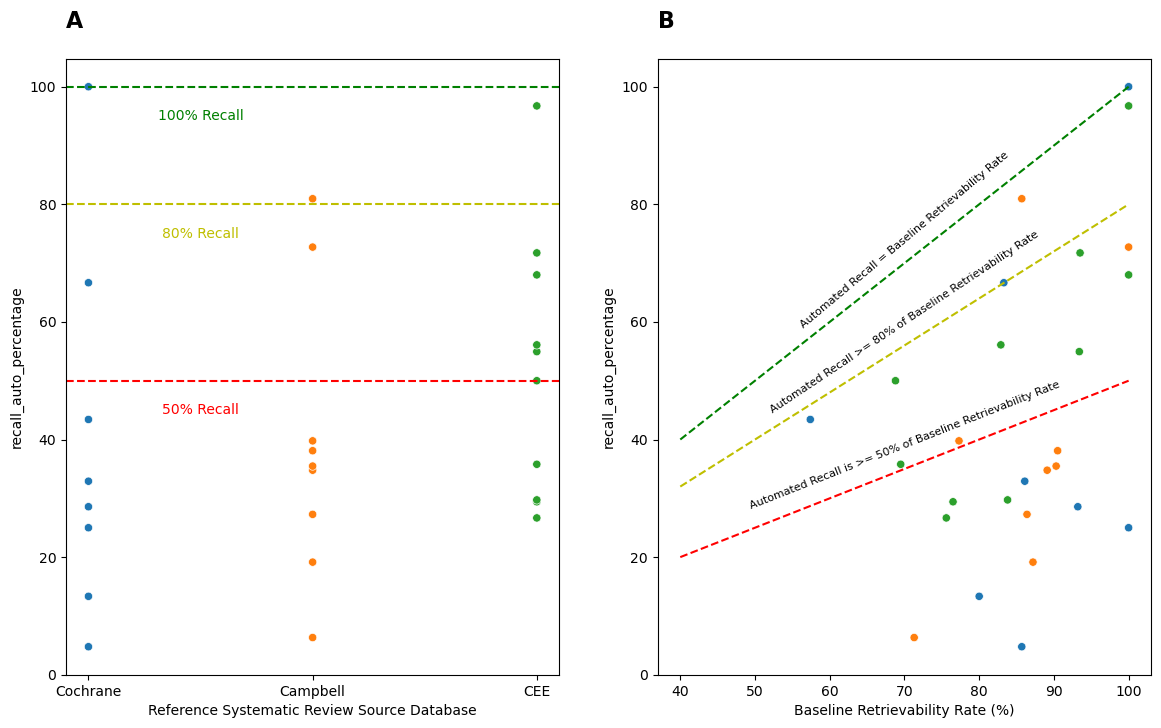

In [24]:
#| label: fig-performance-comparison-recalltheoretical
#| fig-cap: 'Recall of automated citation searching for each systematic review against various level of recall (A), and against theoretical maximum recall of each systematic review (B)'
import math
# Function to Add Dotted Lines and Annotations
def add_dotted_lines(ax, y_values, colors, labels, y_offset):
    for y, color, label in zip(y_values, colors, labels):
        ax.axhline(y=y, color=color, linestyle='--')
        ax.text(0.5, y - y_offset, f"{int(y)}% Recall", color=color, ha="center", va="center")

def add_line_annotations(ax, x_start, x_end, y_start, y_end, labels, x_offset, y_offset):
    for xs, xe, ys, ye, label in zip(x_start, x_end, y_start, y_end, labels):
        delta_x = xe - xs
        delta_y = ye - ys
        angle_offset = -5
        angle = math.atan2(delta_y, delta_x) * (180.0 / math.pi)
        xm = (xs + xe) / 2
        ym = (ys + ye) / 2 + y_offset
        ax.text(xm, ym, label, rotation = angle + angle_offset, ha='center', va='center', fontsize=8)


# Initialize y_offset and other variables for dotted lines
y_values = [100, 80, 50]
colors = ['g', 'y', 'r']
labels = ['100% Recall', '80% Recall', '50% Recall']

# Create the 1x2 Plot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
# Add subplot letters
subplot_letters = ['A', 'B', 'C', 'D']
for ax, letter in zip(axes.flatten(), subplot_letters):
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')
# Plot for Recall against various benchmarks (targets)
sns.scatterplot(x='Reference Systematic Review Source Database', 
                y='recall_auto_percentage', 
                data=result_summary_maxrecall, 
                hue='Reference Systematic Review Source Database', 
                ax=axes[0])
axes[0].legend().remove()
add_dotted_lines(axes[0], y_values, colors, labels, y_offset=5)

# Plot for Recall against Theoretical MAximum Recall
sns.scatterplot(x='Baseline Retrievability Rate (%)',
                y='recall_auto_percentage', 
                data=result_summary_maxrecall, 
                hue='Reference Systematic Review Source Database', 
                ax=axes[1])
axes[1].plot([40, 100], [40,100], color='g', linestyle='--')
axes[1].plot([40, 100], [32,80], color='y', linestyle='--')
axes[1].plot([40, 100], [20,50], color='r', linestyle='--')
axes[1].legend().remove()

x_start = [40, 40, 40]
x_end = [100, 100, 100]
y_start = [40, 32, 20]
y_end = [100, 80, 50]
labels = ["Automated Recall = Baseline Retrievability Rate", "Automated Recall >= 80% of Baseline Retrievability Rate", "Automated Recall is >= 50% of Baseline Retrievability Rate"]

# Add Annotations
add_line_annotations(axes[1], x_start, x_end, y_start, y_end, labels, x_offset = 0,  y_offset=4)

# Table 6: Performance (Precision, F1, F2 and F3 Score) of automated citation searching vs reference systematic review search strategies. 

In [ ]:
#| label: tbl-perfcomparison_autosr
#| tbl-cap: 'Performance (Precision, F1, F2 and F3 Score) of automated citation searching vs sample systematic review.'

from scipy.stats import mannwhitneyu
result_summary_maxrecall_comparison = result_summary_maxrecall.copy() 
result_summary_maxrecall_comparison.rename(columns = {
    'recall_auto_percentage' : 'recall_percentage_auto', 
    'precision_auto_percentage' : 'precision_percentage_auto',
    'recall_sr_percentage' : 'recall_percentage_sr', 
    'precision_sr_percentage' : 'precision_percentage_sr'}, inplace=True)
markdown_table_rows_mwu_autosr = ["| Metric | Automated Citation Searching Performance | Sample Systematic Review Performance | P-value |",
                           "|--------|----------------|----------------|-------------|"]


# Loop through each metric
for metric in [ 'recall_percentage','precision_percentage', 'f1_score', 'f2_score', 'f3_score']:
    metric_a = f"{metric}_auto"
    metric_b = f"{metric}_sr"
    
    group_a = result_summary_maxrecall_comparison[metric_a]
    group_b = result_summary_maxrecall_comparison[metric_b]

    median_a = np.median(group_a)
    median_b = np.median(group_b)
    iqr_a = iqr(group_a)
    iqr_b = iqr(group_b)
    group_a_str = f"{median_a:.3f} ({iqr_a:.3f})"
    group_b_str = f"{median_b:.3f} ({iqr_b:.3f})"
    
    if len(group_a) > 1 and len(group_b) > 1:
        u_statistic, u_p_val = mannwhitneyu(group_a, group_b)
        
        # Bonferroni correction; here it's trivial as you have only two groups for comparison.
        adjusted_u_p_val = min(u_p_val * 1, 1)  

        asterisk_mwu_raw = "*" if u_p_val < 0.05 else ""
        asterisk_mwu_adj = "*" if adjusted_u_p_val < 0.05 else ""

        markdown_table_rows_mwu_autosr.append(f"| {metric} |  {group_a_str} | {group_b_str}| {adjusted_u_p_val:.3f}{asterisk_mwu_adj} |")

# Convert list of Markdown table rows to a single string
markdown_table_mwu_autosr = "\n".join(markdown_table_rows_mwu_autosr)
Markdown(markdown_table_mwu_autosr)

# Figure 3: (A-D) Comparison of Automated Citation Searching Performance (Best Performing Run) vs Search Strategies employed by Sample Systematic Review, by Precision, F1 Score, F2 Score and F3 score. Dots above the dotted line represents outperformance relative to the reference standard

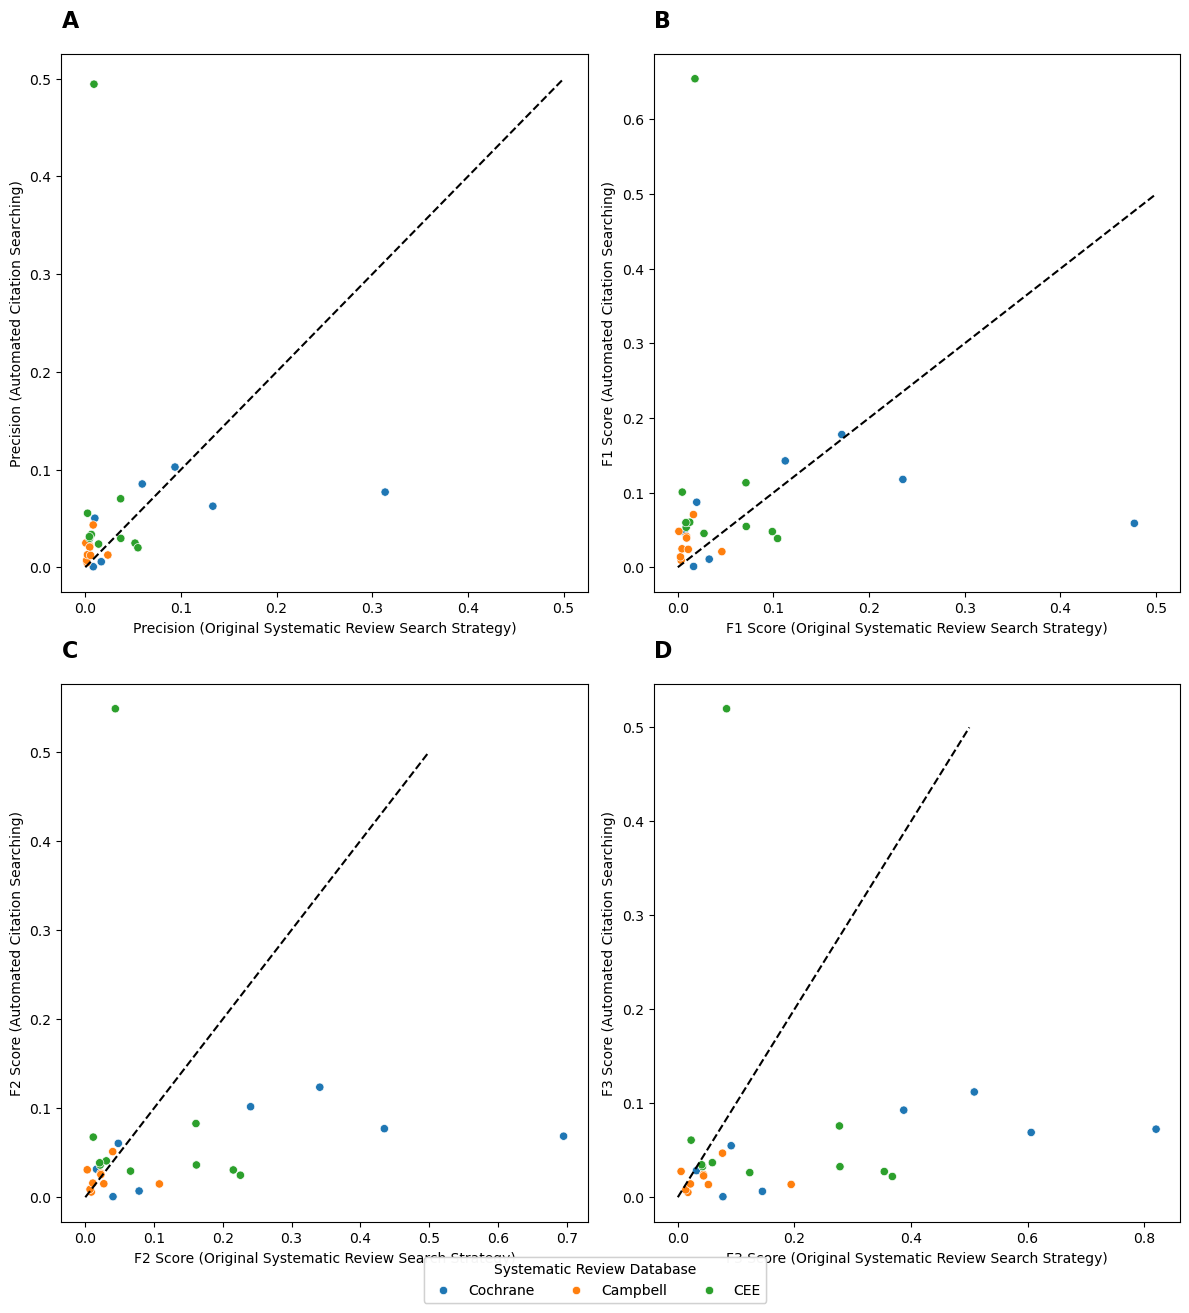

In [26]:
#| label: fig-performance-comparison-autovssr
#| fig-cap: '(A-D) Comparison of Automated Citation Searching Performance (Best Performing Run) vs Search Strategies employed by Sample Systematic Review, by Precision, F1 Score, F2 Score and F3 score.'
#| fig-pos: p

# Function to Add Dotted Lines and Annotations
def add_dotted_lines(ax, y_values, colors, labels, y_offset=0.08):
    for y, color, label in zip(y_values, colors, labels):
        ax.axhline(y=y, color=color, linestyle='--')
        ax.text(0.5, y - y_offset, f"{int(y*100)}% Recall", color=color, ha="center", va="center")


# Initialize y_offset and other variables for dotted lines
y_offset_value = 0.02
y_values = [1.0, 0.8, 0.5]
colors = ['g', 'y', 'r']
labels = ['100% Recall', '80% Recall', '50% Recall']

# Create the 2x2 Plot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 15))
# Add subplot letters
subplot_letters = ['A', 'B', 'C', 'D']
for ax, letter in zip(axes.flatten(), subplot_letters):
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')


# Plot for Precision
sns.scatterplot(x='precision_sr',
                y='precision_auto', 
                data=result_summary_maxrecall, 
                hue='Reference Systematic Review Source Database', 
                ax=axes[0, 0])
axes[0, 0].plot([0, 0.5], [0, 0.5], color='black', linestyle='--')
axes[0, 0].set_xlabel('Precision (Original Systematic Review Search Strategy)')
axes[0, 0].set_ylabel('Precision (Automated Citation Searching)')
axes[0, 0].legend().remove()

# Plot for F1 Score
sns.scatterplot(x='f1_score_sr',
                y='f1_score_auto', 
                data=result_summary_maxrecall, 
                hue='Reference Systematic Review Source Database', 
                ax=axes[0, 1])
axes[0, 1].legend().remove()
axes[0, 1].plot([0, 0.5], [0, 0.5], color='black', linestyle='--')
axes[0, 1].set_xlabel('F1 Score (Original Systematic Review Search Strategy)')
axes[0, 1].set_ylabel('F1 Score (Automated Citation Searching)')
axes[0, 1].legend().remove()

# Plot for F2 Score
sns.scatterplot(x='f2_score_sr',
                y='f2_score_auto', 
                data=result_summary_maxrecall, 
                hue='Reference Systematic Review Source Database', 
                ax=axes[1, 0])
axes[1, 0].legend().remove()
axes[1, 0].plot([0, 0.5], [0, 0.5], color='black', linestyle='--')
axes[1, 0].set_xlabel('F2 Score (Original Systematic Review Search Strategy)')
axes[1, 0].set_ylabel('F2 Score (Automated Citation Searching)')
axes[1, 0].legend().remove()

plt.subplots_adjust(bottom=0.4)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), title='Systematic Review Database', bbox_to_anchor=(0.5, 0.08))  # Adjusted bbox_to_anchor

# Plot for F3 Score
sns.scatterplot(x='f3_score_sr',
                y='f3_score_auto', 
                data=result_summary_maxrecall, 
                hue='Reference Systematic Review Source Database', 
                ax=axes[1, 1])
axes[1, 1].legend().remove()
axes[1, 1].plot([0, 0.5], [0, 0.5], color='black', linestyle='--')
axes[1, 1].set_xlabel('F3 Score (Original Systematic Review Search Strategy)')
axes[1, 1].set_ylabel('F3 Score (Automated Citation Searching)')
axes[1, 1].legend().remove()

plt.subplots_adjust(bottom=0.4)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), title='Systematic Review Database', bbox_to_anchor=(0.5, 0.08))  # Adjusted bbox_to_anchor

plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjusted the tight_layout
plt.show()

# Factors Influencing Automated Citation Searching Performance

In [ ]:
#| label: tbl-numerical_variable_performance_comparison
#| tbl-cap: 'Spearman rank correlation coefficients (Rho, Adjusted P-value (After Bonferroni Correctionm 5 Comparisons for each outcome metric) for intracluster semantic similiarity, number of included articles, number of seed articles, against outcome metrics (Recall, Precision, F(1-3 Score))'

from scipy.stats import spearmanr
# Assuming result_summary_maxrecall is your DataFrame
result_summary_maxrecall.rename(columns = {
    'params.seed_num': 'Number of Seed Articles',
    'included_num' : 'Number of Included Articles',
    'intra_cluster_similarity' : 'Intra-cluster Semantic Similarity'}, inplace = True)

# Define separate lists for factors and outcome metrics
factors = ['Intra-cluster Semantic Similarity', 'Number of Included Articles', 'Number of Seed Articles']
outcome_metrics = ['recall_auto', 'precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']

# Calculate number of comparisons made: One for each combination of factors and outcome metrics
num_comparisons = len(factors)

# Initialize DataFrames to store Spearman correlation coefficients and p-values
spearman_corr_matrix = pd.DataFrame(index=outcome_metrics, columns=factors)
spearman_pvalue_matrix = pd.DataFrame(index=outcome_metrics, columns=factors)
spearman_adjusted_pvalue_matrix = pd.DataFrame(index=outcome_metrics, columns=factors)

# Calculate Spearman correlations and p-values
for factor in factors:
    for metric in outcome_metrics:
        rho, p_value = spearmanr(result_summary_maxrecall[factor], result_summary_maxrecall[metric])
        adjusted_p_value = min(p_value * num_comparisons, 1)
        
        spearman_corr_matrix.loc[metric, factor] = rho
        spearman_pvalue_matrix.loc[metric, factor] = p_value
        spearman_adjusted_pvalue_matrix.loc[metric, factor] = adjusted_p_value

# Combine rho, raw p-value, and adjusted p-value into a single DataFrame
combine_corr_pvalue = pd.DataFrame(index=spearman_corr_matrix.index, columns=spearman_corr_matrix.columns)
for row in spearman_corr_matrix.index:
    for col in spearman_corr_matrix.columns:
        rho = spearman_corr_matrix.loc[row, col]
        raw_pval = spearman_pvalue_matrix.loc[row, col]
        adj_pval = spearman_adjusted_pvalue_matrix.loc[row, col]
        if pd.isna(rho) or pd.isna(raw_pval) or pd.isna(adj_pval):
            combine_corr_pvalue.loc[row, col] = None
        else:
            combine_corr_pvalue.loc[row, col] = f"Rho={rho:.3f}, Raw_p={raw_pval:.3f}, Adj_p={adj_pval:.3f}"

# Convert DataFrame to Markdown table using tabulate
corr_table = tabulate(combine_corr_pvalue, headers='keys', tablefmt='pipe', numalign="right")
Markdown(corr_table)

### Study Area

In [ ]:
#| label: tbl-automated_citation_search_perf_summary
#| tbl-cap: 'Median (IQR) Recall, Precision, F1 score, F2 score, F3 score of the best performing automated citation searching runs, by Systematic Review Subsets'

result_summary_database_source = result_summary.copy()
result_summary_database_source_all = result_summary.copy()
result_summary_database_source_all['Reference Systematic Review Source Database'] = 'All Reviews'
result_summary_database_source = pd.concat([result_summary_database_source, result_summary_database_source_all], ignore_index=True)
result_summary_database_source_grp = result_summary_database_source.groupby(['Reference Systematic Review Source Database']).agg(
    {
        'recall_auto' : ['median', iqr],
        'precision_auto' : ['median', iqr],
        'f1_score_auto' : ['median', iqr],
        'f2_score_auto' : ['median', iqr],
        'f3_score_auto' : ['median', iqr],
        'recall_sr' : ['median', iqr],
        'precision_sr' : ['median', iqr],
        'f1_score_sr' : ['median', iqr],
        'f2_score_sr' : ['median', iqr],
        'f3_score_sr' : ['median', iqr],
    }
).reset_index()
metrics_auto = ['recall_auto', 'precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']
result_summary_database_source_grp.columns = [
    '_'.join(col).rstrip('_') 
    for col in result_summary_database_source_grp.columns.values
]

footnote_dict = {
    'All Reviews' : '*'
}


def format_row(row,footnote_dict):
    median_iqr_recall = f"{row['recall_auto_median']*100:.2f} ({row['recall_auto_iqr']*100:.2f})"
    median_iqr_precision = f"{row['precision_auto_median']*100:.2f} ({row['precision_auto_iqr']*100:.2f})"
    median_iqr_f1_score = f"{row['f1_score_auto_median']:.3f} ({row['f1_score_auto_iqr']:.3f})"
    median_iqr_f2_score = f"{row['f2_score_auto_median']:.3f} ({row['f2_score_auto_iqr']:.3f})"
    median_iqr_f3_score = f"{row['f3_score_auto_median']:.3f} ({row['f3_score_auto_iqr']:.3f})"
    if footnote_dict is not None: 
        footnote = footnote_dict.get(row['Reference Systematic Review Source Database'], '')
    return f"| {row['Reference Systematic Review Source Database']}{footnote} | {median_iqr_recall} | {median_iqr_precision} | {median_iqr_f1_score} | {median_iqr_f2_score} | {median_iqr_f3_score} |"

md_table = "| Systematic Review Subset | Median (IQR) Recall (%) | Median (IQR) Precision (%) | Median (IQR) F1 Score | Median (IQR) F2 Score | Median (IQR) F3 Score |\n"
md_table += "|---|---|---|---|---|---|\n"

#define footnotes
md_table_footnotes = "\n \* Aggregate of all systematic reviews"

for idx, row in result_summary_database_source_grp.iterrows():
    md_table += format_row(row, footnote_dict) + '\n'
md_table += md_table_footnotes
md_table_srsubsets_autoperf  = md_table
Markdown(md_table_srsubsets_autoperf)

# Supplementary Fig: 

In [ ]:
#| label: fig-performance-comparison-srsubset
#| fig-cap: '(A-D) Comparison of Automated Citation Searching Performance (Best Performing Run) within different Systematic Review Subsets, by Precision, F1 Score, F2 Score and F3 score.'
#| fig-pos: p

# Create the 2x2 Plot grid
from matplotlib.patches import Patch
fig, axes = plt.subplots(2, 2, figsize=(12, 15))

# Subplot letters and custom color palette
subplot_letters = ['A', 'B', 'C', 'D']
metrics = ['precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']
custom_palette = {'Cochrane': '#809fff',  # Light blue
                  'CEE': '#70db70',       
                  'Campbell': '#ffd480'}

def add_significance_bracket(ax, x1, x2, y_max, y_range):
    y = y_max + 0.05 * y_range
    bracket_height = 0.02 * y_range
    text_y = y_max + 0.065 * y_range
    p_value = 0.024  # Replace with actual p-value

    # Add the bracket and p-value annotation
    ax.plot([x1, x2], [y, y], color='black')
    ax.plot([x1, x1], [y - bracket_height / 2, y + bracket_height / 2], color='black')
    ax.plot([x2, x2], [y - bracket_height / 2, y + bracket_height / 2], color='black')
    ax.text((x1 + x2) / 2, text_y, f"Adjusted p* = {p_value}, <0.05", ha='center', va='bottom', fontweight='bold')

# Plot boxplots and add annotations
for ax, metric, letter in zip(axes.flatten(), metrics, subplot_letters):
    sns.boxplot(x='Reference Systematic Review Source Database', y=metric, data=result_recall_sorted_extract, palette=custom_palette, ax=ax)
    y_max = result_recall_sorted_extract[metric].max()
    y_min = result_recall_sorted_extract[metric].min()
    y_range = y_max - y_min
    add_significance_bracket(ax, 1, 2, y_max, y_range)
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')

# Collect handles and labels from one of the subplots (they should be the same for all)


# Add a single legend for the entire figure
# Create legend handles manually
legend_elements = [Patch(facecolor='#809fff', edgecolor='#809fff', label='Cochrane'),
                   Patch(facecolor='#70db70', edgecolor='#70db70', label='CEE'),
                   Patch(facecolor='#ffd480', edgecolor='#ffd480', label='Campbell')]

# Add a single legend for the entire figure
fig.legend(handles=legend_elements, loc='lower center', ncol=3, title='Systematic Review Database', bbox_to_anchor=(0.5, 0.08))

# Adjust layout
plt.tight_layout(rect=[0, 0.2, 1, 1])
plt.show()


In [ ]:
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu

# Initialize Markdown table rows for Kruskal-Wallis and Mann-Whitney U
markdown_table_rows_kw = ["| Metric | Kruskal Statistic |  Kruskal p-value (Raw) | Kruskal p-value (Adjusted) |",
                          "|--------|-------------------|----------------------------|----------------------------|"]

markdown_table_rows_mwu = ["| Metric | Comparison | U Statistic | Raw p-value | Adjusted p-value |",
                           "|--------|------------|-------------|-------------|------------------|"]

# Number of Kruskal-Wallis tests being run
num_kw_tests = 1  # Only one test per metric

# New alpha after Bonferroni correction for Kruskal-Wallis
alpha_kw = 0.05 / num_kw_tests

# Loop through each metric
for metric in ['recall_auto', 'precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']:
    groups = {name: group[metric].dropna().values for name, group in result_summary_maxrecall.groupby('Reference Systematic Review Source Database')}
    
    if all(len(g) > 1 for g in groups.values()):
        k_statistic, k_p_val = kruskal(*groups.values())
        adjusted_p_val_kw = min(k_p_val * num_kw_tests, 1)
        
        asterisk_kw_adj = "*" if adjusted_p_val_kw < 0.05 else ""
        asterisk_kw_raw = "*" if adjusted_p_val_kw < 0.05 else ""
        
        markdown_table_rows_kw.append(f"| {metric} | {k_statistic:.2f} | {k_p_val:.3f}{asterisk_kw_raw} |{adjusted_p_val_kw:.3f} {asterisk_kw_adj}|")
        
        if k_p_val < alpha_kw:
            
            mwu_results = []
            combos = list(combinations(groups.keys(), 2))  # Convert to list to find length
            num_combos = len(combos)  # Number of combinations
            for grp1, grp2 in combos:
                u_statistic, u_p_val = mannwhitneyu(groups[grp1], groups[grp2])
                adjusted_u_p_val = min(u_p_val * num_combos, 1)  # Bonferroni correction
               
                asterisk_mwu_raw = "*" if u_p_val < 0.05 else ""
                asterisk_mwu_adj = "*" if adjusted_u_p_val < 0.05 else ""
                
                markdown_table_rows_mwu.append(f"| {metric} | {grp1} vs {grp2} | {u_statistic} | {u_p_val:.3f}{asterisk_mwu_raw} | {adjusted_u_p_val:.3f}{asterisk_mwu_adj} |")

# Convert lists of Markdown table rows to single strings
markdown_table_kw_studyarea = "\n".join(markdown_table_rows_kw)
markdown_table_mwu_studyarea = "\n".join(markdown_table_rows_mwu)

### Seed Article Type

create summary tables alongside hypothesis test results (no difference found so results are inserted into supp table, alongside box plots) - so just describe results and note that variation is not significant


In [ ]:
## this is recall > 0, seed _ num 1 but keep in mind that multiple same seeds may be used for different reviews so need to combine
full_results_valid_recall_filter = full_results_valid_recall[~full_results_valid_recall['params.seed_id'].str.match(r"\['.*'\]")]
full_results_valid_recall_1seed = full_results_valid_recall_filter.query('`params.seed_num` == 1').reset_index()
full_results_valid_recall_1seed['id_cleaned'] = full_results_valid_recall_1seed['params.seed_id'].str.replace(r"[\'\[\]]", "", regex=True)
full_results_valid_recall_1seed_cleaned_oa = full_results_valid_recall_1seed[full_results_valid_recall_1seed['API'] == 'openalex'].reset_index()
full_results_valid_recall_1seed_cleaned_ss = full_results_valid_recall_1seed[full_results_valid_recall_1seed['API'] == 'semanticscholar'].reset_index()

col_interest = ['id_cleaned', 'Original Systematic Review ID', 'source_database','article_type', 'API', 'year', 'precision_auto', 'recall_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto','citations', 'references', 'citation_network_size']
#merge with seed article data 
seed_article_all_oa_rename = seed_articles_all_oa.copy()
seed_article_all_oa_rename.rename(columns = {'year_published' : 'year'}, inplace = True)
seed_article_all_oa_rename['api'] = 'openalex'
seed_articles_all_ss['api'] = 'semanticscholar'

full_results_valid_recall_1seed_cleaned_oa_merge = pd.merge(full_results_valid_recall_1seed_cleaned_oa, seed_article_all_oa_rename[['seed_Id', 'api','title','year', 'article_type', 'article_subtype','source_database', 'citations', 'references', 'citation_network_size']], how='left', left_on=['id_cleaned','API'], right_on=['seed_Id', 'api'])
full_results_valid_recall_1seed_cleaned_oa = full_results_valid_recall_1seed_cleaned_oa_merge[col_interest].copy()
full_results_valid_recall_1seed_cleaned_ss_merge = pd.merge(full_results_valid_recall_1seed_cleaned_ss, seed_articles_all_ss[['seed_Id', 'api', 'title','year', 'article_type', 'article_subtype','source_database', 'citations', 'references','citation_network_size']], how='left', left_on=['id_cleaned','API'], right_on=['seed_Id', 'api'])
full_results_valid_recall_1seed_cleaned_ss = full_results_valid_recall_1seed_cleaned_ss_merge[col_interest].copy()
result_summary_maxrecall['params.seed_id'] = result_summary_maxrecall['params.seed_id'].apply(ast.literal_eval)

#loop through each seed id and obtain corresponding seed article data and recall, precision, f1, f2, f3 scores
best_seed_dict = result_summary_maxrecall[['Original Systematic Review ID', 'params.seed_id', 'API']].to_dict('records')

#loop through params.seed_id and obtain corresponding seed article data
for dct in best_seed_dict: 
    article_type_list = [] 
    recall_list = []
    precision_list = []
    f1_list = []
    f2_list = []
    f3_list = []
    year_published = []

    for id in dct['params.seed_id']:
        original_sr_id = dct['Original Systematic Review ID']
        api = dct['API']
        article_type = seed_articles_all_oa.query('`seed_Id` == @id & `original_sr_id` == @original_sr_id')['article_type'].iloc[0]
        article_type_list.append(article_type)
        recall_list.append(full_results_valid_recall_1seed.query('`params.seed_id` == @id & `API` == @api & `Original Systematic Review ID` == @original_sr_id')['recall_auto'].iloc[0])
        precision_list.append(full_results_valid_recall_1seed.query('`params.seed_id` == @id & `API` == @api & `Original Systematic Review ID` == @original_sr_id')['precision_auto'].iloc[0])
        f1_list.append(full_results_valid_recall_1seed.query('`params.seed_id` == @id & `API` == @api & `Original Systematic Review ID` == @original_sr_id')['f1_score_auto'].iloc[0])
        f2_list.append(full_results_valid_recall_1seed.query('`params.seed_id` == @id & `API` == @api & `Original Systematic Review ID` == @original_sr_id')['f2_score_auto'].iloc[0])
        f3_list.append(full_results_valid_recall_1seed.query('`params.seed_id` == @id & `API` == @api & `Original Systematic Review ID` == @original_sr_id')['f3_score_auto'].iloc[0])
        year_published.append(seed_articles_all_oa.query('`seed_Id` == @id & `original_sr_id` == @original_sr_id')['year_published'].iloc[0])
    dct['article_type'] = article_type_list
    dct['recall_auto'] = recall_list
    dct['precision_auto'] = precision_list
    dct['f1_score_auto'] = f1_list
    dct['f2_score_auto'] = f2_list
    dct['f3_score_auto'] = f3_list
    dct['year_published'] = year_published    

best_seed_df = []
for data_dict in best_seed_dict: 
    length = len(data_dict['params.seed_id'])
    for key, value in data_dict.items():
        if not isinstance(value, list):
            data_dict[key] = [value] * length
    
    # Convert each dictionary to a DataFrame
    df = pd.DataFrame.from_dict(data_dict)
    
    # Append the DataFrame to the list
    best_seed_df.append(df)
    
best_seed_df = pd.concat(best_seed_df, ignore_index = True)
best_seed_df['count'] = 1

#plot box plot of article types against recall, precision, f1, f2, f3 scores
best_seed_type_grp = best_seed_df.groupby(['article_type']).agg({'count' : 'sum', 'recall_auto' : ['median', iqr], 'precision_auto' :['median', iqr], 'f1_score_auto' : ['median', iqr], 'f2_score_auto' : ['median', iqr], 'f3_score_auto' :['median', iqr]}).reset_index()
best_seed_type_grp.columns = ['_'.join(col).rstrip('_') for col in best_seed_type_grp.columns.values]

In [ ]:
#| label: tbl-automated_citation_search_perf_summary_article_type
#| tbl-cap: 'Median (IQR) Recall, Precision, F1 score, F2 score, F3 score of the best performing seed article types'

#create summary table 
best_seed_type_grp = best_seed_type_grp.sort_values(by = 'recall_auto_median', ascending=False)
markdown_table_seed_type = "| Article Type (n) | Median (IQR) Recall (%) | Median (IQR) Precision (%) | Median (IQR) F1 Score | Median (IQR) F2 Score | Median (IQR) F3 Score |\n"
markdown_table_seed_type += "|---|---|---|---|---|---|\n"

for idx, row in best_seed_type_grp.iterrows():
    markdown_table_seed_type += f"| {row['article_type']} ({row['count_sum']}) | {row['recall_auto_median']*100:.2f} ({row['recall_auto_iqr']*100:.2f}) | {row['precision_auto_median']*100:.2f} ({row['precision_auto_iqr']*100:.2f}) | {row['f1_score_auto_median']:.3f} ({row['f1_score_auto_iqr']:.3f}) | {row['f2_score_auto_median']:.3f} ({row['f2_score_auto_iqr']:.3f}) | {row['f3_score_auto_median']:.3f} ({row['f3_score_auto_iqr']:.3f}) |\n"

Markdown(markdown_table_seed_type)

In [ ]:
#Hypothesis test 

# Initialize Markdown table rows for Kruskal-Wallis and Mann-Whitney U
markdown_table_rows_kw = ["| Metric | Kruskal Statistic |  Kruskal p-value (Raw) | Kruskal p-value (Adjusted) |",
                          "|--------|-------------------|----------------------------|----------------------------|"]

markdown_table_rows_mwu = ["| Metric | Comparison | U Statistic | Raw p-value | Adjusted p-value |",
                           "|--------|------------|-------------|-------------|------------------|"]

# Number of Kruskal-Wallis tests being run
num_kw_tests = 1  # Only one test per metric
# New alpha after Bonferroni correction for Kruskal-Wallis
alpha_kw = 0.05 / num_kw_tests
# Loop through each metric
for metric in ['recall_auto', 'precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']:
    groups = {name: group[metric].dropna().values for name, group in best_seed_df.groupby('article_type')}
    
    if all(len(g) > 1 for g in groups.values()):
        k_statistic, k_p_val = kruskal(*groups.values())
        adjusted_p_val_kw = min(k_p_val * num_kw_tests, 1)
        
        asterisk_kw_adj = "*" if adjusted_p_val_kw < 0.05 else ""
        asterisk_kw_raw = "*" if adjusted_p_val_kw < 0.05 else ""
        
        markdown_table_rows_kw.append(f"| {metric} | {k_statistic:.2f} | {k_p_val:.3f}{asterisk_kw_raw} |{adjusted_p_val_kw:.3f} {asterisk_kw_adj}|")
        
        if k_p_val < alpha_kw:
            
            mwu_results = []
            combos = list(combinations(groups.keys(), 2))  # Convert to list to find length
            num_combos = len(combos)  # Number of combinations
            for grp1, grp2 in combos:
                u_statistic, u_p_val = mannwhitneyu(groups[grp1], groups[grp2])
                adjusted_u_p_val = min(u_p_val * num_combos, 1)  # Bonferroni correction
               
                asterisk_mwu_raw = "*" if u_p_val < 0.05 else ""
                asterisk_mwu_adj = "*" if adjusted_u_p_val < 0.05 else ""
                
                markdown_table_rows_mwu.append(f"| {metric} | {grp1} vs {grp2} | {u_statistic} | {u_p_val:.3f}{asterisk_mwu_raw} | {adjusted_u_p_val:.3f}{asterisk_mwu_adj} |")

# Convert lists of Markdown table rows to single strings
markdown_table_kw = "\n".join(markdown_table_rows_kw)
markdown_table_mwu = "\n".join(markdown_table_rows_mwu)
#supp tables 
markdown_table_kw_seedtype = markdown_table_kw
markdown_table_mwu_seedtype = markdown_table_mwu

### Study Type Inclusion Criteria

compare grey lit vs peer reviewed only - no difference - keep same format as study area

*create table with summary results - and denote whether significant or not (asterisk) - raw kruskal statistic - put in supplementary info*


In [ ]:
## summary results table 
result_summary_maxrecall['count'] = 1
result_inc_criteria_summary = result_summary_maxrecall.groupby(['included_study_type_selection_criteria']).agg({
    'count' : 'sum',
    'recall_auto' : ['median', iqr],
    'precision_auto' : ['median', iqr],
    'f1_score_auto' : ['median', iqr],
    'f2_score_auto' : ['median', iqr],
    'f3_score_auto' : ['median', iqr]
}).reset_index() 
result_inc_criteria_summary.columns = ['_'.join(col).rstrip('_') for col in result_inc_criteria_summary.columns.values]
result_inc_criteria_summary.sort_values(by=['recall_auto_median'], ascending=False, inplace=True)

In [ ]:
#| label: tbl-automated_citation_search_perf_summary_inc_criteria
#| tbl-cap: 'Median (IQR) Recall, Precision, F1 score, F2 score, F3 score, by study inclusion criteria'

markdown_table_inc_criteria = "| Inclusion Criteria (n) | Median (IQR) Recall (%) | Median (IQR) Precision (%) | Median (IQR) F1 Score | Median (IQR) F2 Score | Median (IQR) F3 Score |\n"
markdown_table_inc_criteria += "|---|---|---|---|---|---|\n"

for idx, row in result_inc_criteria_summary.iterrows():
    markdown_table_inc_criteria += f"| {row['included_study_type_selection_criteria']} ({row['count_sum']}) | {row['recall_auto_median']*100:.2f} ({row['recall_auto_iqr']*100:.2f}) | {row['precision_auto_median']*100:.2f} ({row['precision_auto_iqr']*100:.2f}) | {row['f1_score_auto_median']:.3f} ({row['f1_score_auto_iqr']:.3f}) | {row['f2_score_auto_median']:.3f} ({row['f2_score_auto_iqr']:.3f}) | {row['f3_score_auto_median']:.3f} ({row['f3_score_auto_iqr']:.3f}) |\n"

Markdown(markdown_table_inc_criteria)

In [ ]:
# Initialize Markdown table rows for Kruskal-Wallis and Mann-Whitney U
markdown_table_rows_kw = ["| Metric | Kruskal Statistic |  Kruskal p-value (Raw) | Kruskal p-value (Adjusted) |",
                          "|--------|-------------------|----------------------------|----------------------------|"]

markdown_table_rows_mwu = ["| Metric | Comparison | U Statistic | Raw p-value | Adjusted p-value |",
                           "|--------|------------|-------------|-------------|------------------|"]

# Number of Kruskal-Wallis tests being run
num_kw_tests = 1  # Only one test per metric

# New alpha after Bonferroni correction for Kruskal-Wallis
alpha_kw = 0.05 / num_kw_tests

# Loop through each metric
for metric in ['recall_auto', 'precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']:
    groups = {name: group[metric].dropna().values for name, group in result_summary_maxrecall.groupby('included_study_type_selection_criteria')}
    
    if all(len(g) > 1 for g in groups.values()):
        k_statistic, k_p_val = kruskal(*groups.values())
        adjusted_p_val_kw = min(k_p_val * num_kw_tests, 1)
        
        asterisk_kw_adj = "*" if adjusted_p_val_kw < 0.05 else ""
        asterisk_kw_raw = "*" if adjusted_p_val_kw < 0.05 else ""
        
        markdown_table_rows_kw.append(f"| {metric} | {k_statistic:.2f} | {k_p_val:.3f}{asterisk_kw_raw} |{adjusted_p_val_kw:.3f} {asterisk_kw_adj}|")

        if k_p_val < alpha_kw:
            
            mwu_results = []
            combos = list(combinations(groups.keys(), 2))  # Convert to list to find length
            num_combos = len(combos)  # Number of combinations
            for grp1, grp2 in combos:
                u_statistic, u_p_val = mannwhitneyu(groups[grp1], groups[grp2])
                adjusted_u_p_val = min(u_p_val * num_combos, 1)  # Bonferroni correction
               
                asterisk_mwu_raw = "*" if u_p_val < 0.05 else ""
                asterisk_mwu_adj = "*" if adjusted_u_p_val < 0.05 else ""
                
                markdown_table_rows_mwu.append(f"| {metric} | {grp1} vs {grp2} | {u_statistic} | {u_p_val:.3f}{asterisk_mwu_raw} | {adjusted_u_p_val:.3f}{asterisk_mwu_adj} |")

# Convert lists of Markdown table rows to single strings
markdown_table_kw = "\n".join(markdown_table_rows_kw)
markdown_table_mwu = "\n".join(markdown_table_rows_mwu)
markdown_table_inc_criteira_kw = markdown_table_kw
markdown_table_inc_criteria_mwu = markdown_table_mwu

### API Choice

Hypothesis test (mann whitney u) - no difference + symmart tabe


In [ ]:
#| tbl-cap: 'Median (IQR) Recall, Precision, F1 Score, F2 score and F3 score of the best performing automated citation searching runs from each API'
#summary table 


result_best_performing_oa = (
    full_results_valid_recall[full_results_valid_recall['API'] == 'openalex']
    .sort_values(by=['Original Systematic Review ID', 'recall_auto', 'f3_score_auto'], ascending=[True, False, False])
    .groupby('Original Systematic Review ID')
    .first()
    .reset_index()
)

result_best_performing_ss = (    full_results_valid_recall[full_results_valid_recall['API'] == 'semanticscholar']
    .sort_values(by=['Original Systematic Review ID', 'recall_auto', 'f3_score_auto'], ascending=[True, False, False])
    .groupby('Original Systematic Review ID')
    .first()
    .reset_index()
                            )
result_best_performing_bothapi = pd.concat([result_best_performing_oa, result_best_performing_ss], ignore_index=True)

result_best_performing_bothapi_summary = result_best_performing_bothapi.groupby('API').agg(
    {
        'recall_auto' : ['median', iqr],
        'precision_auto' : ['median', iqr],
        'f1_score_auto' : ['median', iqr],
        'f2_score_auto' : ['median', iqr],
        'f3_score_auto' : ['median', iqr],
    }
).reset_index()

#flatten column names and structure as markdown table 
result_best_performing_bothapi_summary.columns = ['_'.join(col).rstrip('_') for col in result_best_performing_bothapi_summary.columns.values]


In [ ]:
#| label: tbl-automated_citation_search_perf_summary_api
#| tbl-cap: 'Median (IQR) Recall, Precision, F1 Score, F2 score and F3 score of the best performing automated citation searching runs from each API'
#summary table 

markdown_table_api = "| API | Median (IQR) Recall (%) | Median (IQR) Precision (%) | Median (IQR) F1 Score | Median (IQR) F2 Score | Median (IQR) F3 Score |\n"
markdown_table_api += "|---|---|---|---|---|---|\n"

for idx, row in result_best_performing_bothapi_summary.iterrows():
    markdown_table_api += f"| {row['API']} | {row['recall_auto_median']*100:.2f} ({row['recall_auto_iqr']*100:.2f}) | {row['precision_auto_median']*100:.2f} ({row['precision_auto_iqr']*100:.2f}) | {row['f1_score_auto_median']:.3f} ({row['f1_score_auto_iqr']:.3f}) | {row['f2_score_auto_median']:.3f} ({row['f2_score_auto_iqr']:.3f}) | {row['f3_score_auto_median']:.3f} ({row['f3_score_auto_iqr']:.3f}) |\n"

Markdown(markdown_table_api)

In [ ]:
# Initialize a list to hold Markdown table rows
markdown_table_rows = ["| Metric | Comparison | U Statistic | Raw p-value | Adjusted p-value | Significant |",
                       "|--------|------------|-------------|-------------|------------------|-------------|"]

# Initialize alpha for Bonferroni correction
alpha = 0.05

for metric in ['recall_auto', 'precision_auto', 'f1_score_auto', 'f2_score_auto', 'f3_score_auto']:
    groups = {name: group[metric].dropna().values for name, group in result_best_performing_bothapi.groupby('API')}
    
    # Run Mann-Whitney U test for pairwise comparisons
    if all(len(g) > 1 for g in groups.values()):
        mwu_results = []
        combos = combinations(groups.keys(), 2)
        for grp1, grp2 in combos:
            u_statistic, u_p_val = mannwhitneyu(groups[grp1], groups[grp2])
            mwu_results.append((grp1, grp2, u_statistic, u_p_val))
        
        # Bonferroni Correction
        num_comparisons = len(mwu_results)
        corrected_alpha = alpha / num_comparisons
        
        for grp1, grp2, u_statistic, u_p_val in mwu_results:
            adjusted_p_val = min(u_p_val * num_comparisons, 1)
            significance_str = "*" if adjusted_p_val < corrected_alpha else ""
            markdown_table_rows.append(f"| {metric} | {grp1} vs {grp2} | {u_statistic:.2f} | {u_p_val:.3f} | {adjusted_p_val:.3f}{significance_str} | {significance_str} |")

# Convert list of Markdown table rows to a single string
markdown_table_api_kw = "\n".join(markdown_table_rows)


# Extra Supplementary Tables

**Table S1 : Sample Systematic Review Characteristics (Title, Source Database, Publication Year, Search Strategy, Study Type Inclusion Criteria)**

| \#  | Title                                                                                                                                                                                        | Source Database  | Publication Year | Search Strategy                                                                                | Study Type Inclusion Criteria             |
|:----------:|------------|------------|------------|------------|------------|
|  1  | Mechanisms of Impact of Blue Spaces on Human Health: A Systematic Literature Review and Meta-Analysis                                                                                        | CEEDER           | 2021             | boolean keyword + backwards citation search                                                    | peer-reviewed literature                  |
|  2  | A systematic review of the socio-economic impacts of large-scale tree plantations, worldwide                                                                                                 | CEEDER           | 2018             | boolean keyword + backwards citation search + handsearch                                       | peer-reviewed literature, grey literature |
|  3  | Are small protected habitat patches within boreal production forests effective in conserving species richness, abundance and community composition? A systematic review                      | CEEDER           | 2021             | boolean keyword + full citation search + handsearch + expert consultation                      | peer-reviewed literature, grey literature |
|  4  | What is the effect of phasing out long-chain per- and polyfluoroalkyl substances on the concentrations of perfluoroalkyl acids and their precursors in the environment? A systematic review  | CEEDER           | 2018             | boolean keyword + handsearch + expert consultation                                             | peer-reviewed literature, grey literature |
|  5  | How does roadside vegetation management affect the diversity of vascular plants and invertebrates? A systematic review                                                                       | CEEDER           | 2018             | boolean keyword + prior evidence map                                                           | peer-reviewed literature, grey literature |
|  6  | The effectiveness of non-native fish removal techniques in freshwater ecosystems: a systematic review                                                                                        | CEEDER           | 2019             | boolean keyword + backwards citation search + handsearch + expert consultation + crowdsourcing | peer-reviewed literature, grey literature |
|  7  | Impacts of dead wood manipulation on the biodiversity of temperate and boreal forests. A systematic review                                                                                   | CEEDER           | 2019             | boolean keyword + handsearch + prior evidence map                                              | peer-reviewed literature, grey literature |
|  8  | The Different Dimensions of Livelihood Impacts of Payments for Environmental Services (PES) Schemes: A Systematic Review                                                                     | CEEDER           | 2018             | boolean keyword                                                                                | peer-reviewed literature, grey literature |
|  9  | The effectiveness of spawning habitat creation or enhancement for substrate-spawning temperate fish: a systematic review                                                                     | CEEDER           | 2019             | boolean keyword + backwards citation search + handsearch + crowdsourcing                       | peer-reviewed literature, grey literature |
| 10  | What are the effects of even-aged and uneven-aged forest management on boreal forest biodiversity in Fennoscandia and European Russia? A systematic review                                   | CEEDER           | 2021             | boolean keyword + full citation search + handsearch                                            | peer-reviewed literature, grey literature |
| 11  | Strengthening women's empowerment and gender equality in fragile contexts towards peaceful and inclusive societies: A systematic review and meta‐analysis                                    | Campbell Reviews | 2022             | boolean keyword + full citation search + handsearch                                            | peer-reviewed literature, grey literature |
| 12  | Red light camera interventions for reducing traffic violations and traffic crashes: A systematic review                                                                                      | Campbell Reviews | 2020             | boolean keyword + backward citation search + handsearch                                        | peer-reviewed literature, grey literature |
| 13  | Aquaculture for improving productivity, income, nutrition and women's empowerment in low‐ and middle‐income countries: A systematic review and meta‐analysis                                 | Campbell Reviews | 2021             | boolean keyword + full citation search + handsearch                                            | peer-reviewed literature, grey literature |
| 14  | Policies and interventions to remove gender‐related barriers to girls' school participation and learning in low‐ and middle‐income countries: A systematic review of the evidence            | Campbell Reviews | 2022             | boolean keyword + backwards citation search + handsearch                                       | peer-reviewed literature, grey literature |
| 15  | Citizen engagement in public services in low‐ and middle‐income countries: A mixed‐methods systematic review of participation, inclusion, transparency and accountability (PITA) initiatives | Campbell Reviews | 2019             | boolean keyword + backwards citation search + handsearch                                       | peer-reviewed literature, grey literature |
| 16  | The impacts of agroforestry interventions on agricultural productivity, ecosystem services, and human well‐being in low‐ and middle‐income countries: A systematic review                    | Campbell Reviews | 2021             | boolean keyword + full citation search + handsearch + prior evidence map                       | peer-reviewed literature, grey literature |
| 17  | Multiagency programs with police as a partner for reducing radicalisation to violence                                                                                                        | Campbell Reviews | 2021             | boolean keyword + full citation search + expert consultation                                   | peer-reviewed literature, grey literature |
| 18  | Adult/child ratio and group size in early childhood education or care to promote the development of children aged 0--5 years: A systematic review                                            | Campbell Reviews | 2022             | boolean keyword + full citation search + handsearch + expert consultation                      | peer-reviewed literature, grey literature |
| 19  | Interventions for improving executive functions in children with foetal alcohol spectrum disorder (FASD): A systematic review                                                                | Campbell Reviews | 2022             | boolean keyword + full citation search + handsearch + expert consultation                      | peer-reviewed literature, grey literature |
| 20  | Selective serotonin reuptake inhibitors (SSRIs) for stroke recovery                                                                                                                          | CDSR             | 2021             | boolean keyword + backwards citation search + expert consultation                              | peer-reviewed literature                  |
| 21  | Vena caval filters for the prevention of pulmonary embolism                                                                                                                                  | CDSR             | 2020             | boolean keyword + forward citation + previous version of review                                | peer-reviewed literature                  |
| 22  | Atovaquone-proguanil for treating uncomplicated Plasmodium falciparum malaria                                                                                                                | CDSR             | 2021             | boolean keyword + backwards citation search + previous version of review                       | peer-reviewed literature                  |
| 23  | Pharmaceutical policies: effects of regulating drug insurance schemes                                                                                                                        | CDSR             | 2022             | boolean keyword + backwards citation search + expert consultation                              | peer-reviewed literature, grey literature |
| 24  | Ab interno supraciliary microstent surgery for open-angle glaucoma                                                                                                                           | CDSR             | 2021             | boolean keyword + backwards citation search + handsearch                                       | peer-reviewed literature                  |
| 25  | Probiotics for the prevention of Hirschsprung-associated enterocolitis                                                                                                                       | CDSR             | 2022             | boolean keyword + backwards citation search + expert consultation                              | peer-reviewed literature                  |
| 26  | Pentoxifylline for the treatment of endometriosis-associated pain and infertility                                                                                                            | CDSR             | 2021             | boolean keyword + backwards citation search + expert consultation                              | peer-reviewed literature                  |
| 27  | How effects on health equity are assessed in systematic reviews of interventions                                                                                                             | CDSR             | 2022             | boolean keyword + backwards citation search + expert consultation + previous version of review | peer-reviewed literature, grey literature |


In [ ]:
#| label: tbl-theoretical_max_recall_raw
#| tbl-cap: 'Perentage of Included Articles with Retrieval IDs, and corresponding theoretical maximum achievable recall for each API (OpenAlex and Semantic Scholar), for each Systematic Review'


##supplementary table

def calculate_retrieval_stats(df, original_sr_id, included_num):
    stats = {}
    mask = df['original_sr_id'] == original_sr_id
    filtered_df = df[mask]

    stats['no_id_num'] = filtered_df['no_id'].sum()
    stats['no_data_from_api_num'] = filtered_df['no_data_from_api'].sum()
    stats['no_id_no_api_num'] = filtered_df['no_data_no_id'].sum()
    stats['api_success_retrieved_num'] = sum(filtered_df['no_data_no_id'] == 0)
    stats['retrievable_id_num'] = included_num - stats['no_id_num']
    

    if included_num != 0:
        stats['no_id_percentage'] = round((stats['no_id_num'] / included_num) * 100, 1)
        stats['no_data_api_percentage'] = round((stats['no_data_from_api_num'] / included_num) * 100, 1)
        stats['api_success_retrieved_percentage'] = round((stats['api_success_retrieved_num'] / included_num) * 100, 1)
        stats['retrievable_id_percentage'] = round((stats['retrievable_id_num'] / included_num) * 100, 1)

        stats['no_id_percentage_with_counts'] = f"{stats['no_id_percentage']} % (n={stats['no_id_num']})"
        stats['retrievable_id_percentage_with_counts'] = f"{stats['retrievable_id_percentage']} % (n={stats['retrievable_id_num']})"
        stats['no_data_api_percentage_with_counts'] = f"{stats['no_data_api_percentage']} % (n={stats['no_data_from_api_num']})"
        stats['success_retrieved_percentage_with_counts'] = f"{stats['api_success_retrieved_percentage']} % (n={stats['api_success_retrieved_num']})"
    else:
        stats['no_id_percentage'] = 0
        stats['no_data_api_percentage'] = 0
        stats['success_retrieved_percentage'] = 0
        stats['no_id_percentage_with_counts'] = f"{stats['no_id_percentage']}% (n={stats['no_id_num']})"
        stats['no_data_api_percentage_with_counts'] = f"{stats['no_data_api_percentage']}% (n={stats['no_data_from_api_num']})"
        stats['success_retrieved_percentage_with_counts'] = f"{stats['success_retrieved_percentage']}% (n={stats['success_retrieved_num']})"
        stats['retrievable_id_percentage_with_counts'] = f"{stats['retrievable_id_percentage']}% (n={stats['retrievable_id_num']})"

    return stats

original_sr_all = baseline_review_data_oa.copy()

for original_sr_id in original_sr_all['id'].unique():
    mask_oa = included_all_oa['original_sr_id'] == original_sr_id
    mask_ss = included_all_ss['original_sr_id'] == original_sr_id
    included_num = len(included_all_oa[mask_oa])

    stats_oa = calculate_retrieval_stats(included_all_oa, original_sr_id, included_num)
    stats_ss = calculate_retrieval_stats(included_all_ss, original_sr_id, included_num)

    original_sr_all.loc[original_sr_all['id'] == original_sr_id, 'included_num'] = included_num

    for prefix, stats in {'oa': stats_oa, 'ss': stats_ss}.items():
        for key, value in stats.items():
            original_sr_all.loc[original_sr_all['id'] == original_sr_id, f"{key}_{prefix}"] = value

extract_col = ['source_database', 'included_num', 'retrievable_id_percentage_with_counts_ss','success_retrieved_percentage_with_counts_oa','success_retrieved_percentage_with_counts_ss']
original_sr_performance_df = original_sr_all[extract_col].copy()
original_sr_performance_df.rename(columns = {'retrievable_id_percentage_with_counts_ss':'retrievable_id_percentage_with_counts'}, inplace = True)

extract_col_new = ['source_database', 'included_num', 'retrievable_id_percentage_with_counts','success_retrieved_percentage_with_counts_oa','success_retrieved_percentage_with_counts_ss']

## change column names 
target_col_names = ['Source Database', 'Number of Included Articles', 'Percentage of Included Articles with Retrievable IDs', 'Maximum Theoretical Recall (OpenAlex)', 'Maximum Theoretical Recall (Semantic Scholar)']
col_name_mapping = dict(zip(extract_col_new, target_col_names))
original_sr_performance_df.rename(columns = col_name_mapping, inplace=True)


# Generate Markdown; the string formatting should be preserved
markdown_table = original_sr_performance_df.to_markdown()

# # Convert DataFrame back to original dtypes
# for col in baseline_review_data_oa.columns:
#     baseline_review_data_oa[col] = baseline_review_data_oa[col].astype(original_dtypes[col])

Markdown(markdown_table)

In [ ]:
#| label: tbl-kw_test_studyarea
#| tbl-cap: 'Kruskal Wallis test results for Study Area vs Performance (Recall, Precision, F1 Score, F2 Score, F3 Score)'

Markdown(markdown_table_kw_studyarea)

In [ ]:
#| label: tbl-mwu_test_studyarea
#| tbl-cap: 'Mann Whitney U test results for Study Area Pairwise Comparisons vs Performance (Recall, Precision, F1 Score, F2 Score, F3 Score)'
Markdown(markdown_table_mwu_studyarea)

In [ ]:
#| label: tbl-kw_test_seedtype
#| tbl-cap: 'Kruskal Wallis test results for Seed Article Types vs Performance (Recall, Precision, F1 Score, F2 Score, F3 Score)'
Markdown(markdown_table_kw_seedtype)

In [ ]:
#| label: fig-seed_perf-precisionrecall
#| fig-cap: Box plot of various seed article types vs recall (A) and precision (B). Only seed article types with n>5 are plotted.
#plot box plot 
best_seed_df_filter_samplesize = best_seed_df.query('article_type not in  ["consensus article", "framework"]')

# Create the 2x1 Plot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# Add subplot letters
subplot_letters = ['A', 'B']

for ax, letter in zip(axes.flatten(), subplot_letters):
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')

# Plot for Recall
sns.boxplot(x='article_type', 
            y='recall_auto', 
            data=best_seed_df_filter_samplesize, 
            ax=axes[0])
axes[0].legend().remove()
axes[0].set_xlabel('Seed Article Type')
plt.xticks(rotation=45)
# Plot for Precision
sns.boxplot(x='article_type', 
            y='precision_auto', 
            data=best_seed_df_filter_samplesize, 
            ax=axes[1])
axes[1].legend().remove() 
axes[1].set_xlabel('Seed Article Type')
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjusted the tight_layout
plt.show()

In [ ]:
#| label: fig-seed_perf-fscore
#| fig-cap: Box plot of various seed article types vs F-1 Score (A) F2 Score (B) and (C) F3 Score. Only seed article types with n>5 are plotted.

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
subplot_letters = ['A', 'B', 'C']

for ax, letter in zip(axes.flatten(), subplot_letters):
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')

# Plot for F1 Score
sns.boxplot(x='article_type', 
            y='f1_score_auto', 
            data=best_seed_df_filter_samplesize, 
            ax=axes[0])
axes[0].set_xlabel('Seed Article Type')

# Plot for F2 Score
sns.boxplot(x='article_type', 
            y='f2_score_auto', 
            data=best_seed_df_filter_samplesize, 
            ax=axes[1])
axes[1].set_xlabel('Seed Article Type')

# Plot for F3 Score
sns.boxplot(x='article_type', 
            y='f3_score_auto', 
            data=best_seed_df_filter_samplesize, 
            ax=axes[2])
axes[2].set_xlabel('Seed Article Type')
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.show()

In [ ]:
#| label: tbl-kw_test_inc_criteria
#| tbl-cap: 'Kruskal Wallis test results for Inclusion Criteria Types vs Performance (Recall, Precision, F1 Score, F2 Score, F3 Score)'
Markdown(markdown_table_inc_criteira_kw)

In [ ]:
#| label: fig-performance-comparison-peerreviewgrey-recallprecision
#| fig-cap: 'Boxplot of (A) Recall and (B) Precision, by study type inclusion criteria'


# Create the 2x1 Plot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# Add subplot letters
subplot_letters = ['A', 'B']

for ax, letter in zip(axes.flatten(), subplot_letters):
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')

# Plot for Recall
sns.boxplot(x='included_study_type_selection_criteria', 
            y='recall_auto', 
            data=result_summary_maxrecall, 
            ax=axes[0])
axes[0].legend().remove()
axes[0].set_xlabel('Included Study Selection Criteria')

# Plot for Precision
sns.boxplot(x='included_study_type_selection_criteria', 
            y='precision_auto', 
            data=result_summary_maxrecall, 
            ax=axes[1])
axes[1].legend().remove() 
axes[1].set_xlabel('Included Study Selection Criteria')
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjusted the tight_layout
plt.show()

In [ ]:
#| label: fig-performance-comparison-peerreviewgrey-fscore
#| fig-cap: 'Boxplot of F1 score, F2 score and F3 score by study type inclusion criteria'
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
subplot_letters = ['A', 'B', 'C']

for ax, letter in zip(axes.flatten(), subplot_letters):
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')

# Plot for F1 Score
sns.boxplot(x='included_study_type_selection_criteria', 
            y='f1_score_auto', 
            data=result_summary_maxrecall, 
            ax=axes[0])
axes[0].set_xlabel('Included Study Selection Criteria')

# Plot for F2 Score
sns.boxplot(x='included_study_type_selection_criteria', 
            y='f2_score_auto', 
            data=result_summary_maxrecall, 
            ax=axes[1])
axes[1].set_xlabel('Included Study Selection Criteria')

# Plot for F3 Score
sns.boxplot(x='included_study_type_selection_criteria', 
            y='f3_score_auto', 
            data=result_summary_maxrecall, 
            ax=axes[2])
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

axes[2].set_xlabel('Included Study Selection Criteria')
plt.show()

In [ ]:
#| label: tbl-kw_test_api
#| tbl-cap: 'Kruskal Wallis test results for API Choice vs Performance (Recall, Precision, F1 Score, F2 Score, F3 Score)'

Markdown(markdown_table_api_kw)

In [ ]:
#| label: fig-performance-comparison-api-recallprecision
#| fig-cap: Boxplot of (A) Recall and (B) Precision of the best performing automated citation searching runs for each API

# Create the 2x1 Plot grid
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Add subplot letters
subplot_letters = ['A', 'B']
custom_palette_api = {'openalex': '#809fff',  # Light blue
                  'semanticscholar': '#70db70',}

for ax, letter in zip(axes.flatten(), subplot_letters):
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')


# Plot for Recall
sns.boxplot(x='API', 
            y='recall_auto', 
            data=result_best_performing_bothapi, 
            palette = custom_palette_api,
            ax=axes[0])
axes[0].set_xlabel('API')

# Plot for Precision
sns.boxplot(x='API', 
            y='precision_auto', 
            data=result_best_performing_bothapi, 
            palette = custom_palette_api,
            ax=axes[1])
axes[1].set_xlabel('API')
plt.show()

In [ ]:
#| label: fig-performance-comparison-api-fscore
#| fig-cap: 'Boxplot of (A) F1 Score, (B) F2 Score, and (C) F3 Score of the best performing automated citation searching runs for each API'
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
subplot_letters = ['A', 'B', 'C']

for ax, letter in zip(axes.flatten(), subplot_letters):
    ax.text(0, 1.05, letter, transform=ax.transAxes, fontsize=16, fontweight='bold')

# Plot for F1 Score
sns.boxplot(x='API', 
            y='f1_score_auto', 
            data=result_best_performing_bothapi, 
            palette = custom_palette_api,
            ax=axes[0])
axes[0].set_xlabel('API')

# Plot for F2 Score
sns.boxplot(x='API', 
            y='f2_score_auto', 
            data=result_best_performing_bothapi, 
            palette = custom_palette_api,
            ax=axes[1])
axes[1].set_xlabel('API')

# Plot for F3 Score
sns.boxplot(x='API', 
            y='f3_score_auto', 
            data=result_best_performing_bothapi, 
            palette = custom_palette_api,
            ax=axes[2])
axes[2].set_xlabel('API')
plt.show()